In [1]:
# Load modules

import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import sys
import os
sys.path.append('..')
from types import SimpleNamespace
from field_of_junctions import FieldOfJunctions
import nbimporter

from torchsummary import summary

from Dataset_Maker_Lines import make_random_line_set, make_grey_transform
from Dataset_Maker_Junctions import make_random_junction_set, make_grey_transform_junc

# %load_ext autoreload
# %reload_ext autoreload

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# %load_ext autoreload
%autoreload 2

UsageError: Line magic function `%autoreload` not found.


In [5]:
class LineDataset(torch.utils.data.Dataset):
    """ Dataset with support of transforms.
    """

    def __init__(self, images, params, boundaries, wedges, transform=None):
        self.images = images
        self.params = params
        self.boundaries = boundaries
        self.wedges = wedges
        self.transform = transform

    def __getitem__(self, index):
        
        image = self.images[index]
        wedge = self.wedges[index]

        if self.transform:
            image = self.transform(image)
            
        param = self.params[index].squeeze()
        boundary = self.boundaries[index]
        
        return image, param, boundary, wedge

    def __len__(self):
        return len(self.images)

In [6]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('LazyLinear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0) 
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)
    if classname.find('Conv2d') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)
        

# Learn 5x5 patches

In [87]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_5_125000_grey_multicolor_with_solid_noise_random_.2_uncentered.pkl','rb') as f:
# with open(data_folder + 'line_data_5_125000_grey_bicolor_with_solid_noise_random_.2_uncentered.pkl','rb') as f:
# with open(data_folder + 'line_data_5_100000_grey_bicolor_noise_random_.2_uncentered.pkl','rb') as f:


    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']

125000


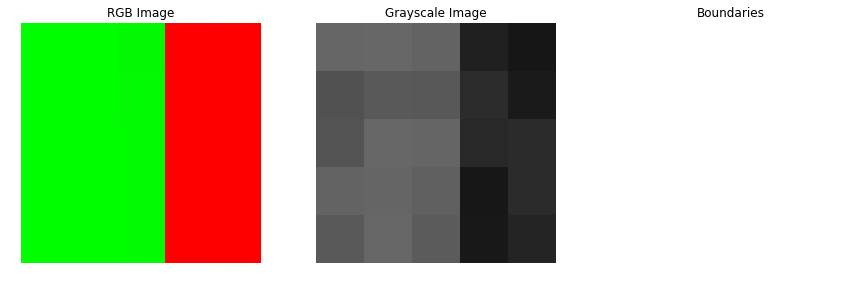

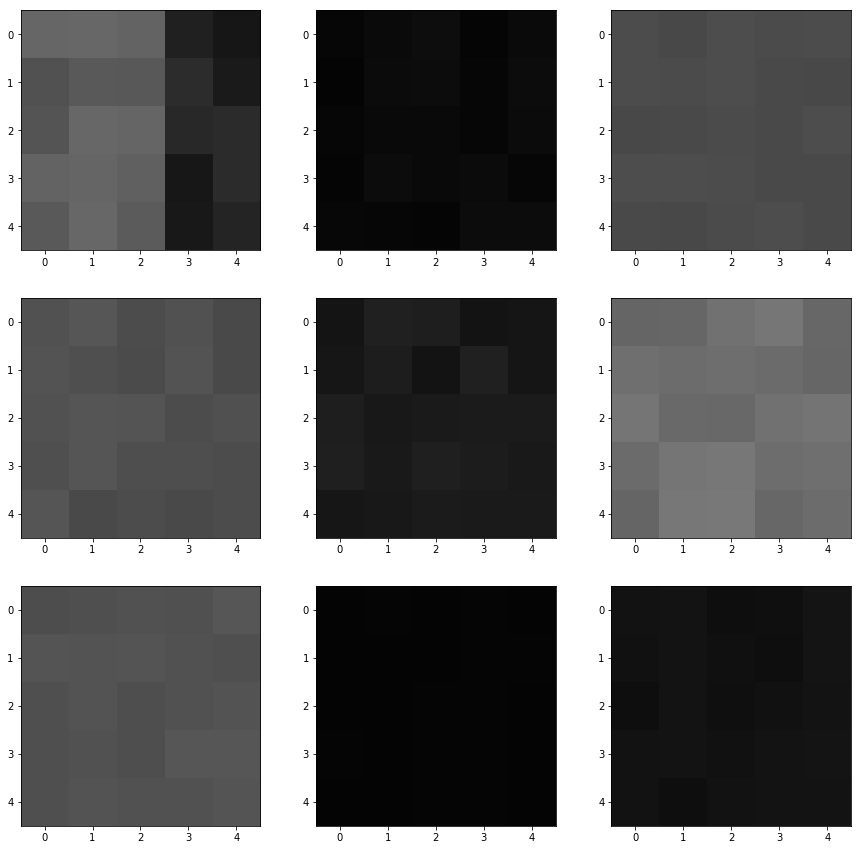

In [88]:
line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


W,H = wedges_grey.shape[-1],wedges_grey.shape[-1]

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(331)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(332)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(333)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(wedges_grey[-ii,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
#     print(params[-ii,:])

# img_show = 1
# plt.subplot(334)
# plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
# plt.title('RGB Image')
# plt.axis('off');
# plt.subplot(335)
# plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
# plt.title('Grayscale Image')
# plt.axis('off');
# plt.subplot(336)
# plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
# plt.title('Boundaries')
# plt.axis('off');

# img_show = 2
# plt.subplot(337)
# plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
# plt.title('RGB Image')
# plt.axis('off');
# plt.subplot(338)
# plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
# plt.title('Grayscale Image')
# plt.axis('off');
# plt.subplot(339)
# plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
# plt.title('Boundaries')
# plt.axis('off');



In [99]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2) #64 is good
        self.conv2 = nn.Conv2d(16, 16, kernel_size=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=2)
        self.fc = nn.LazyLinear(3)
        self.activate = nn.ReLU()
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.activate(x)
        x = self.conv2(x)
        x = self.activate(x)
        x = self.conv3(x)
        x = self.activate(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 16, 4, 4]              80
              ReLU-2             [-1, 16, 4, 4]               0
            Conv2d-3             [-1, 16, 3, 3]           1,040
              ReLU-4             [-1, 16, 3, 3]               0
            Conv2d-5             [-1, 32, 2, 2]           2,080
              ReLU-6             [-1, 32, 2, 2]               0
            Linear-7                    [-1, 3]             387
Total params: 3,587
Trainable params: 3,587
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 0.8393065358433768, Avg. Test Loss: 0.94573575258255
Epoch: 2, Avg. Train Loss: 0.9765731330229858, Avg. Test Loss: 0.9500005841255188
Epoch: 3, Avg. Train Loss: 0.8176417205935327, Avg. Test Loss: 0.6857632398605347
Epoch: 4, Avg. Train Loss: 0.6113745369643808, Avg. Test Loss: 0.5548104643821716
Epoch: 5, Avg. Train Loss: 0.5257218911826054, Avg. Test Loss: 0.49205344915390015
Epoch: 6, Avg. Train Loss: 0.4405780988875951, Avg. Test Loss: 0.3939116299152374
Epoch: 7, Avg. Train Loss: 0.35823870568631966, Avg. Test Loss: 0.32960790395736694
Epoch: 8, Avg. Train Loss: 0.3683805070190786, Avg. Test Loss: 0.5951171517372131
Epoch: 9, Avg. Train Loss: 0.39129332710649367, Avg. Test Loss: 0.3075348436832428
Epoch: 10, Avg. Train Loss: 0.332386258049546, Avg. Test Loss: 0.3081599175930023
Epoch: 11, Avg. Train Loss: 0.35860126987795965, Avg. Test Loss: 0.3484448790550232
Epoch: 12, Avg. Train Loss: 0.3492915936719591, Avg. Test Loss: 0.3227522671222687
Epoch: 13, 

Epoch: 99, Avg. Train Loss: 0.12231123043554966, Avg. Test Loss: 0.12012648582458496
Epoch: 100, Avg. Train Loss: 0.11782925965908532, Avg. Test Loss: 0.11707910895347595
Epoch: 101, Avg. Train Loss: 0.12032831000668981, Avg. Test Loss: 0.13684791326522827
Epoch: 102, Avg. Train Loss: 0.13022585979131895, Avg. Test Loss: 0.11488549411296844
Epoch: 103, Avg. Train Loss: 0.11352481699992563, Avg. Test Loss: 0.11156740039587021
Epoch: 104, Avg. Train Loss: 0.11031071723343056, Avg. Test Loss: 0.10972769558429718
Epoch: 105, Avg. Train Loss: 0.10839214273423792, Avg. Test Loss: 0.10880603641271591
Epoch: 106, Avg. Train Loss: 0.10710225504970997, Avg. Test Loss: 0.10757233202457428
Epoch: 107, Avg. Train Loss: 0.1060438682542783, Avg. Test Loss: 0.1064571738243103
Epoch: 108, Avg. Train Loss: 0.1052107824204124, Avg. Test Loss: 0.10533184558153152
Epoch: 109, Avg. Train Loss: 0.1039582942133752, Avg. Test Loss: 0.10409365594387054
Epoch: 110, Avg. Train Loss: 0.10281417337811996, Avg. Test

Epoch: 195, Avg. Train Loss: 0.03586371272593458, Avg. Test Loss: 0.039766304194927216
Epoch: 196, Avg. Train Loss: 0.03573940102463571, Avg. Test Loss: 0.0373472198843956
Epoch: 197, Avg. Train Loss: 0.03501688072753844, Avg. Test Loss: 0.037346769124269485
Epoch: 198, Avg. Train Loss: 0.0351376493644213, Avg. Test Loss: 0.03706973418593407
Epoch: 199, Avg. Train Loss: 0.034810267667347024, Avg. Test Loss: 0.038171567022800446
Epoch: 200, Avg. Train Loss: 0.03414254565940839, Avg. Test Loss: 0.03634104132652283
Epoch: 201, Avg. Train Loss: 0.03389581120529465, Avg. Test Loss: 0.03313426673412323
Epoch: 202, Avg. Train Loss: 0.03370622756116301, Avg. Test Loss: 0.035577453672885895
Epoch: 203, Avg. Train Loss: 0.03449139449849864, Avg. Test Loss: 0.04150154069066048
Epoch: 204, Avg. Train Loss: 0.03547861122430485, Avg. Test Loss: 0.035319793969392776
Epoch: 205, Avg. Train Loss: 0.033660474120177954, Avg. Test Loss: 0.03869783878326416
Epoch: 206, Avg. Train Loss: 0.032645755647638136

Epoch: 290, Avg. Train Loss: 0.021930697051999726, Avg. Test Loss: 0.023788025602698326
Epoch: 291, Avg. Train Loss: 0.021503765962878677, Avg. Test Loss: 0.023660268634557724
Epoch: 292, Avg. Train Loss: 0.021436279918128087, Avg. Test Loss: 0.023624366149306297
Epoch: 293, Avg. Train Loss: 0.022586191943454965, Avg. Test Loss: 0.023176342248916626
Epoch: 294, Avg. Train Loss: 0.022996736655586235, Avg. Test Loss: 0.023738637566566467
Epoch: 295, Avg. Train Loss: 0.02250350347641751, Avg. Test Loss: 0.024631280452013016
Epoch: 296, Avg. Train Loss: 0.022567935592590647, Avg. Test Loss: 0.024150317534804344
Epoch: 297, Avg. Train Loss: 0.022191433566752995, Avg. Test Loss: 0.023664964362978935
Epoch: 298, Avg. Train Loss: 0.02217757790654062, Avg. Test Loss: 0.023679306730628014
Epoch: 299, Avg. Train Loss: 0.0219747496803648, Avg. Test Loss: 0.02333851344883442
Epoch: 300, Avg. Train Loss: 0.021754172917838408, Avg. Test Loss: 0.02317698486149311
Epoch: 301, Avg. Train Loss: 0.0220518

Epoch: 385, Avg. Train Loss: 0.015436106744422534, Avg. Test Loss: 0.020298736169934273
Epoch: 386, Avg. Train Loss: 0.015438761440253704, Avg. Test Loss: 0.017507271841168404
Epoch: 387, Avg. Train Loss: 0.015870253538068767, Avg. Test Loss: 0.017506366595625877
Epoch: 388, Avg. Train Loss: 0.01575784547968167, Avg. Test Loss: 0.02017747052013874
Epoch: 389, Avg. Train Loss: 0.015193138384721546, Avg. Test Loss: 0.017895368859171867
Epoch: 390, Avg. Train Loss: 0.015316701642124453, Avg. Test Loss: 0.017692167311906815
Epoch: 391, Avg. Train Loss: 0.015443650405053223, Avg. Test Loss: 0.017270557582378387
Epoch: 392, Avg. Train Loss: 0.015992992400914154, Avg. Test Loss: 0.02016557566821575
Epoch: 393, Avg. Train Loss: 0.015212874676788522, Avg. Test Loss: 0.01780817285180092
Epoch: 394, Avg. Train Loss: 0.016095769487182113, Avg. Test Loss: 0.024292971938848495
Epoch: 395, Avg. Train Loss: 0.015142825040444036, Avg. Test Loss: 0.017073776572942734
Epoch: 396, Avg. Train Loss: 0.01524

Epoch: 479, Avg. Train Loss: 0.013519935275071135, Avg. Test Loss: 0.013039826415479183
Epoch: 480, Avg. Train Loss: 0.01322234544694145, Avg. Test Loss: 0.012863310985267162
Epoch: 481, Avg. Train Loss: 0.013012592767791771, Avg. Test Loss: 0.01540585421025753
Epoch: 482, Avg. Train Loss: 0.01324494041624331, Avg. Test Loss: 0.013212534599006176
Epoch: 483, Avg. Train Loss: 0.013109160308665204, Avg. Test Loss: 0.012884293682873249
Epoch: 484, Avg. Train Loss: 0.012841637794659517, Avg. Test Loss: 0.01282074861228466
Epoch: 485, Avg. Train Loss: 0.013666694209188502, Avg. Test Loss: 0.012586286291480064
Epoch: 486, Avg. Train Loss: 0.013300243390845918, Avg. Test Loss: 0.012961377389729023
Epoch: 487, Avg. Train Loss: 0.012851147137791197, Avg. Test Loss: 0.01419471763074398
Epoch: 488, Avg. Train Loss: 0.013281027782081721, Avg. Test Loss: 0.013440010137856007
Epoch: 489, Avg. Train Loss: 0.012875253896046187, Avg. Test Loss: 0.01260469201952219
Epoch: 490, Avg. Train Loss: 0.0137463

Epoch: 573, Avg. Train Loss: 0.011736663058400154, Avg. Test Loss: 0.013416205532848835
Epoch: 574, Avg. Train Loss: 0.011616898369844829, Avg. Test Loss: 0.011344880796968937
Epoch: 575, Avg. Train Loss: 0.011363590114410514, Avg. Test Loss: 0.011249421164393425
Epoch: 576, Avg. Train Loss: 0.011051167516368572, Avg. Test Loss: 0.011108902283012867
Epoch: 577, Avg. Train Loss: 0.011242471073936914, Avg. Test Loss: 0.011105994693934917
Epoch: 578, Avg. Train Loss: 0.011837872789702683, Avg. Test Loss: 0.010734222829341888
Epoch: 579, Avg. Train Loss: 0.011754202086339208, Avg. Test Loss: 0.014708437956869602
Epoch: 580, Avg. Train Loss: 0.011728500085665243, Avg. Test Loss: 0.01188940741121769
Epoch: 581, Avg. Train Loss: 0.01185160512365749, Avg. Test Loss: 0.011183029040694237
Epoch: 582, Avg. Train Loss: 0.011514565402589669, Avg. Test Loss: 0.011701613664627075
Epoch: 583, Avg. Train Loss: 0.011734481626756001, Avg. Test Loss: 0.013253911398351192
Epoch: 584, Avg. Train Loss: 0.011

Epoch: 667, Avg. Train Loss: 0.010149863570336705, Avg. Test Loss: 0.010810300707817078
Epoch: 668, Avg. Train Loss: 0.009828642785340269, Avg. Test Loss: 0.012163408100605011
Epoch: 669, Avg. Train Loss: 0.009700605319377697, Avg. Test Loss: 0.010706671513617039
Epoch: 670, Avg. Train Loss: 0.00952874881293729, Avg. Test Loss: 0.010917606763541698
Epoch: 671, Avg. Train Loss: 0.009788343160648211, Avg. Test Loss: 0.010717137716710567
Epoch: 672, Avg. Train Loss: 0.009651370059315847, Avg. Test Loss: 0.009823483414947987
Epoch: 673, Avg. Train Loss: 0.009567845882586787, Avg. Test Loss: 0.010344019159674644
Epoch: 674, Avg. Train Loss: 0.010088078111897563, Avg. Test Loss: 0.01018452737480402
Epoch: 675, Avg. Train Loss: 0.010543769582340094, Avg. Test Loss: 0.011647120118141174
Epoch: 676, Avg. Train Loss: 0.010553243482990242, Avg. Test Loss: 0.011740204878151417
Epoch: 677, Avg. Train Loss: 0.010644676233424204, Avg. Test Loss: 0.01169259287416935
Epoch: 678, Avg. Train Loss: 0.0100

Epoch: 761, Avg. Train Loss: 0.00917255172123001, Avg. Test Loss: 0.009533382952213287
Epoch: 762, Avg. Train Loss: 0.009173103560319293, Avg. Test Loss: 0.00992031954228878
Epoch: 763, Avg. Train Loss: 0.009112866186301843, Avg. Test Loss: 0.009308245964348316
Epoch: 764, Avg. Train Loss: 0.00896944737096674, Avg. Test Loss: 0.011586080305278301
Epoch: 765, Avg. Train Loss: 0.009146577896219548, Avg. Test Loss: 0.010604782029986382
Epoch: 766, Avg. Train Loss: 0.0092655574406767, Avg. Test Loss: 0.010661010630428791
Epoch: 767, Avg. Train Loss: 0.009882383871057603, Avg. Test Loss: 0.011088156141340733
Epoch: 768, Avg. Train Loss: 0.010328376200050116, Avg. Test Loss: 0.00963834673166275
Epoch: 769, Avg. Train Loss: 0.009775129795318173, Avg. Test Loss: 0.009598905220627785
Epoch: 770, Avg. Train Loss: 0.009726171912712472, Avg. Test Loss: 0.011226896196603775
Epoch: 771, Avg. Train Loss: 0.010123167935515119, Avg. Test Loss: 0.009754680097103119
Epoch: 772, Avg. Train Loss: 0.0099185

Epoch: 855, Avg. Train Loss: 0.008980772497184644, Avg. Test Loss: 0.011209317483007908
Epoch: 856, Avg. Train Loss: 0.008126960845368209, Avg. Test Loss: 0.008875628933310509
Epoch: 857, Avg. Train Loss: 0.008400949562473274, Avg. Test Loss: 0.011292279697954655
Epoch: 858, Avg. Train Loss: 0.008646142625502336, Avg. Test Loss: 0.010274309664964676
Epoch: 859, Avg. Train Loss: 0.008793638462078906, Avg. Test Loss: 0.008444936014711857
Epoch: 860, Avg. Train Loss: 0.00824423422862854, Avg. Test Loss: 0.008545263670384884
Epoch: 861, Avg. Train Loss: 0.008120107573291686, Avg. Test Loss: 0.008614673279225826
Epoch: 862, Avg. Train Loss: 0.008152705225571294, Avg. Test Loss: 0.008057846687734127
Epoch: 863, Avg. Train Loss: 0.008244682834527202, Avg. Test Loss: 0.008599413558840752
Epoch: 864, Avg. Train Loss: 0.008558063093294328, Avg. Test Loss: 0.008983459323644638
Epoch: 865, Avg. Train Loss: 0.008175843295197343, Avg. Test Loss: 0.00849564466625452
Epoch: 866, Avg. Train Loss: 0.008

Epoch: 949, Avg. Train Loss: 0.0073591411488008835, Avg. Test Loss: 0.008199261501431465
Epoch: 950, Avg. Train Loss: 0.007271797152532038, Avg. Test Loss: 0.00819694809615612
Epoch: 951, Avg. Train Loss: 0.00739525865206373, Avg. Test Loss: 0.008500016294419765
Epoch: 952, Avg. Train Loss: 0.0075497630652841, Avg. Test Loss: 0.008902818895876408
Epoch: 953, Avg. Train Loss: 0.007449110834989871, Avg. Test Loss: 0.00882805697619915
Epoch: 954, Avg. Train Loss: 0.00743144605674337, Avg. Test Loss: 0.00836691539734602
Epoch: 955, Avg. Train Loss: 0.0072196148875578545, Avg. Test Loss: 0.00805655401200056
Epoch: 956, Avg. Train Loss: 0.007751985000463846, Avg. Test Loss: 0.008297036401927471
Epoch: 957, Avg. Train Loss: 0.007913443198967203, Avg. Test Loss: 0.007943250238895416
Epoch: 958, Avg. Train Loss: 0.007971441146926345, Avg. Test Loss: 0.009947133250534534
Epoch: 959, Avg. Train Loss: 0.007466301208831997, Avg. Test Loss: 0.008364503271877766
Epoch: 960, Avg. Train Loss: 0.0079643

Epoch: 1074, Avg. Train Loss: 0.007451714982635507, Avg. Test Loss: 0.009499071165919304
Epoch: 1075, Avg. Train Loss: 0.00731624813454452, Avg. Test Loss: 0.008201980963349342
Epoch: 1076, Avg. Train Loss: 0.007406813666990427, Avg. Test Loss: 0.008845377713441849
Epoch: 1077, Avg. Train Loss: 0.007049191912862463, Avg. Test Loss: 0.008223898708820343
Epoch: 1078, Avg. Train Loss: 0.007302027948583676, Avg. Test Loss: 0.008570645935833454
Epoch: 1079, Avg. Train Loss: 0.007280947375067762, Avg. Test Loss: 0.00938656646758318
Epoch: 1080, Avg. Train Loss: 0.007054215658316824, Avg. Test Loss: 0.00766238896176219
Epoch: 1081, Avg. Train Loss: 0.007384213301240005, Avg. Test Loss: 0.008188389241695404
Epoch: 1082, Avg. Train Loss: 0.007846149537607889, Avg. Test Loss: 0.008991486392915249
Epoch: 1083, Avg. Train Loss: 0.00768947952087516, Avg. Test Loss: 0.008415169082581997
Epoch: 1084, Avg. Train Loss: 0.007185957285740944, Avg. Test Loss: 0.00721863703802228
Epoch: 1085, Avg. Train Lo

Epoch: 1167, Avg. Train Loss: 0.005807348627109673, Avg. Test Loss: 0.006930978503078222
Epoch: 1168, Avg. Train Loss: 0.006242026183231969, Avg. Test Loss: 0.006269088480621576
Epoch: 1169, Avg. Train Loss: 0.0060999710025770645, Avg. Test Loss: 0.00739397993311286
Epoch: 1170, Avg. Train Loss: 0.0062739932082732704, Avg. Test Loss: 0.006186323240399361
Epoch: 1171, Avg. Train Loss: 0.0056897196766406855, Avg. Test Loss: 0.006028214935213327
Epoch: 1172, Avg. Train Loss: 0.005905306589067261, Avg. Test Loss: 0.006418307311832905
Epoch: 1173, Avg. Train Loss: 0.005834174303285708, Avg. Test Loss: 0.00666444655507803
Epoch: 1174, Avg. Train Loss: 0.005619831213501291, Avg. Test Loss: 0.005784230772405863
Epoch: 1175, Avg. Train Loss: 0.005533626760034082, Avg. Test Loss: 0.008162922225892544
Epoch: 1176, Avg. Train Loss: 0.006290811423003395, Avg. Test Loss: 0.005642622709274292
Epoch: 1177, Avg. Train Loss: 0.0057668768774683235, Avg. Test Loss: 0.006318754516541958
Epoch: 1178, Avg. T

Epoch: 1259, Avg. Train Loss: 0.005952799801549343, Avg. Test Loss: 0.005717070773243904
Epoch: 1260, Avg. Train Loss: 0.005589088059474375, Avg. Test Loss: 0.006626336835324764
Epoch: 1261, Avg. Train Loss: 0.005615171436742644, Avg. Test Loss: 0.006888085510581732
Epoch: 1262, Avg. Train Loss: 0.005738676503892535, Avg. Test Loss: 0.005777127109467983
Epoch: 1263, Avg. Train Loss: 0.0052482153846072814, Avg. Test Loss: 0.005544290412217379
Epoch: 1264, Avg. Train Loss: 0.0055660256706874505, Avg. Test Loss: 0.006347173824906349
Epoch: 1265, Avg. Train Loss: 0.00525116282471708, Avg. Test Loss: 0.005935868714004755
Epoch: 1266, Avg. Train Loss: 0.0053930449752119655, Avg. Test Loss: 0.006522663868963718
Epoch: 1267, Avg. Train Loss: 0.005540404142376697, Avg. Test Loss: 0.005451594945043325
Epoch: 1268, Avg. Train Loss: 0.005435032410999742, Avg. Test Loss: 0.005779067054390907
Epoch: 1269, Avg. Train Loss: 0.00553869118774745, Avg. Test Loss: 0.0056569380685687065
Epoch: 1270, Avg. T

Epoch: 1351, Avg. Train Loss: 0.005033690410570424, Avg. Test Loss: 0.004679983947426081
Epoch: 1352, Avg. Train Loss: 0.00486773426130971, Avg. Test Loss: 0.005610196385532618
Epoch: 1353, Avg. Train Loss: 0.004776034665198248, Avg. Test Loss: 0.007418834138661623
Epoch: 1354, Avg. Train Loss: 0.0049029075166332385, Avg. Test Loss: 0.005632078740745783
Epoch: 1355, Avg. Train Loss: 0.005379182904540936, Avg. Test Loss: 0.00594724528491497
Epoch: 1356, Avg. Train Loss: 0.004877023755738111, Avg. Test Loss: 0.005955731030553579
Epoch: 1357, Avg. Train Loss: 0.005072329336968816, Avg. Test Loss: 0.004985942505300045
Epoch: 1358, Avg. Train Loss: 0.005358212298896408, Avg. Test Loss: 0.005161403678357601
Epoch: 1359, Avg. Train Loss: 0.00490683999574073, Avg. Test Loss: 0.005229567177593708
Epoch: 1360, Avg. Train Loss: 0.004878518639445723, Avg. Test Loss: 0.005250161048024893
Epoch: 1361, Avg. Train Loss: 0.004857351814144265, Avg. Test Loss: 0.00495248893275857
Epoch: 1362, Avg. Train 

Epoch: 1443, Avg. Train Loss: 0.004603010280249275, Avg. Test Loss: 0.004845854360610247
Epoch: 1444, Avg. Train Loss: 0.004510978728567607, Avg. Test Loss: 0.0044506811536848545
Epoch: 1445, Avg. Train Loss: 0.0050534554713658085, Avg. Test Loss: 0.006299687549471855
Epoch: 1446, Avg. Train Loss: 0.005375703583497589, Avg. Test Loss: 0.0060238586738705635
Epoch: 1447, Avg. Train Loss: 0.005000014589211651, Avg. Test Loss: 0.005563702434301376
Epoch: 1448, Avg. Train Loss: 0.005303552013029841, Avg. Test Loss: 0.005921556148678064
Epoch: 1449, Avg. Train Loss: 0.005092626977189679, Avg. Test Loss: 0.005587280727922916
Epoch: 1450, Avg. Train Loss: 0.004914409348253753, Avg. Test Loss: 0.005513582844287157
Epoch: 1451, Avg. Train Loss: 0.005158132253319164, Avg. Test Loss: 0.004747352562844753
Epoch: 1452, Avg. Train Loss: 0.005001199142311082, Avg. Test Loss: 0.004468468949198723
Epoch: 1453, Avg. Train Loss: 0.004510215146327826, Avg. Test Loss: 0.005516937468200922
Epoch: 1454, Avg. 

Epoch: 1536, Avg. Train Loss: 0.004694513724159415, Avg. Test Loss: 0.004492688458412886
Epoch: 1537, Avg. Train Loss: 0.0050149802771336, Avg. Test Loss: 0.004705912433564663
Epoch: 1538, Avg. Train Loss: 0.0044333141788875105, Avg. Test Loss: 0.004977168515324593
Epoch: 1539, Avg. Train Loss: 0.004718958850619253, Avg. Test Loss: 0.0044714403338730335
Epoch: 1540, Avg. Train Loss: 0.004611756112948756, Avg. Test Loss: 0.005356496199965477
Epoch: 1541, Avg. Train Loss: 0.004886348435881539, Avg. Test Loss: 0.004639213904738426
Epoch: 1542, Avg. Train Loss: 0.0047563169147192596, Avg. Test Loss: 0.005230316426604986
Epoch: 1543, Avg. Train Loss: 0.004387849691611166, Avg. Test Loss: 0.004490905441343784
Epoch: 1544, Avg. Train Loss: 0.004357767147751891, Avg. Test Loss: 0.004537755623459816
Epoch: 1545, Avg. Train Loss: 0.004906678056588101, Avg. Test Loss: 0.005131160374730825
Epoch: 1546, Avg. Train Loss: 0.004622730839927898, Avg. Test Loss: 0.0043171062134206295
Epoch: 1547, Avg. T

Epoch: 1628, Avg. Train Loss: 0.00496026654901836, Avg. Test Loss: 0.0047262911684811115
Epoch: 1629, Avg. Train Loss: 0.00458934970165246, Avg. Test Loss: 0.0050956024788320065
Epoch: 1630, Avg. Train Loss: 0.0043957933574636406, Avg. Test Loss: 0.004582110792398453
Epoch: 1631, Avg. Train Loss: 0.005077817076904194, Avg. Test Loss: 0.0045639402233064175
Epoch: 1632, Avg. Train Loss: 0.004955068596194837, Avg. Test Loss: 0.004636801313608885
Epoch: 1633, Avg. Train Loss: 0.004372044459907947, Avg. Test Loss: 0.004545959178358316
Epoch: 1634, Avg. Train Loss: 0.004400680363874569, Avg. Test Loss: 0.005387489218264818
Epoch: 1635, Avg. Train Loss: 0.004449789051105765, Avg. Test Loss: 0.00527646578848362
Epoch: 1636, Avg. Train Loss: 0.004934448174366327, Avg. Test Loss: 0.004413689952343702
Epoch: 1637, Avg. Train Loss: 0.004311765591988218, Avg. Test Loss: 0.006381264887750149
Epoch: 1638, Avg. Train Loss: 0.004510453342956221, Avg. Test Loss: 0.004909671377390623
Epoch: 1639, Avg. Tr

Epoch: 1720, Avg. Train Loss: 0.0042877539831309396, Avg. Test Loss: 0.0041915071196854115
Epoch: 1721, Avg. Train Loss: 0.004322424866085019, Avg. Test Loss: 0.004357339348644018
Epoch: 1722, Avg. Train Loss: 0.004165360007748426, Avg. Test Loss: 0.004479287192225456
Epoch: 1723, Avg. Train Loss: 0.004151790063375625, Avg. Test Loss: 0.004248341079801321
Epoch: 1724, Avg. Train Loss: 0.0044067298153537176, Avg. Test Loss: 0.0041486890986561775
Epoch: 1725, Avg. Train Loss: 0.004072309939504088, Avg. Test Loss: 0.004502291791141033
Epoch: 1726, Avg. Train Loss: 0.004326024286396732, Avg. Test Loss: 0.004312601871788502
Epoch: 1727, Avg. Train Loss: 0.004132302499715692, Avg. Test Loss: 0.0045776162296533585
Epoch: 1728, Avg. Train Loss: 0.0042404296055053164, Avg. Test Loss: 0.006863692309707403
Epoch: 1729, Avg. Train Loss: 0.004574693178009486, Avg. Test Loss: 0.004598097410053015
Epoch: 1730, Avg. Train Loss: 0.00429261082165361, Avg. Test Loss: 0.004258610308170319
Epoch: 1731, Avg

Epoch: 1812, Avg. Train Loss: 0.0042248728606745466, Avg. Test Loss: 0.005092540290206671
Epoch: 1813, Avg. Train Loss: 0.004235282475041731, Avg. Test Loss: 0.00456269970163703
Epoch: 1814, Avg. Train Loss: 0.004684893307754788, Avg. Test Loss: 0.0047098807990550995
Epoch: 1815, Avg. Train Loss: 0.0039020461078176152, Avg. Test Loss: 0.003953175153583288
Epoch: 1816, Avg. Train Loss: 0.004011092235325513, Avg. Test Loss: 0.004026127979159355
Epoch: 1817, Avg. Train Loss: 0.004184698601140179, Avg. Test Loss: 0.004698548931628466
Epoch: 1818, Avg. Train Loss: 0.004335132420985637, Avg. Test Loss: 0.004398121498525143
Epoch: 1819, Avg. Train Loss: 0.004456336533859651, Avg. Test Loss: 0.004471661988645792
Epoch: 1820, Avg. Train Loss: 0.004056909186852591, Avg. Test Loss: 0.003941302187740803
Epoch: 1821, Avg. Train Loss: 0.003941722810442481, Avg. Test Loss: 0.004738467279821634
Epoch: 1822, Avg. Train Loss: 0.004110006323937222, Avg. Test Loss: 0.003984291106462479
Epoch: 1823, Avg. T

Epoch: 1904, Avg. Train Loss: 0.00402597512692979, Avg. Test Loss: 0.0037888665683567524
Epoch: 1905, Avg. Train Loss: 0.0039231841926785, Avg. Test Loss: 0.004504159092903137
Epoch: 1906, Avg. Train Loss: 0.0039853135441543066, Avg. Test Loss: 0.0043207695707678795
Epoch: 1907, Avg. Train Loss: 0.003994040968001028, Avg. Test Loss: 0.0040029375813901424
Epoch: 1908, Avg. Train Loss: 0.0038905578695899137, Avg. Test Loss: 0.003783527296036482
Epoch: 1909, Avg. Train Loss: 0.003960544154239453, Avg. Test Loss: 0.004932764917612076
Epoch: 1910, Avg. Train Loss: 0.0041536495446392865, Avg. Test Loss: 0.0049397507682442665
Epoch: 1911, Avg. Train Loss: 0.004032967305333118, Avg. Test Loss: 0.004280135966837406
Epoch: 1912, Avg. Train Loss: 0.004028556039382782, Avg. Test Loss: 0.00426009576767683
Epoch: 1913, Avg. Train Loss: 0.003919801783582596, Avg. Test Loss: 0.004940810613334179
Epoch: 1914, Avg. Train Loss: 0.004021065359691454, Avg. Test Loss: 0.003907303791493177
Epoch: 1915, Avg. 

Epoch: 1996, Avg. Train Loss: 0.003860386773926493, Avg. Test Loss: 0.003944179508835077
Epoch: 1997, Avg. Train Loss: 0.004008804526284476, Avg. Test Loss: 0.0037422673776745796
Epoch: 1998, Avg. Train Loss: 0.0036617210287182966, Avg. Test Loss: 0.004068818874657154
Epoch: 1999, Avg. Train Loss: 0.003778054298415223, Avg. Test Loss: 0.0043830787762999535
Epoch: 2000, Avg. Train Loss: 0.0037321308997642494, Avg. Test Loss: 0.004061507061123848
Epoch: 2001, Avg. Train Loss: 0.0036644315081605008, Avg. Test Loss: 0.0037447488866746426
Epoch: 2002, Avg. Train Loss: 0.0037045812269098292, Avg. Test Loss: 0.003939016722142696
Epoch: 2003, Avg. Train Loss: 0.0040990994986425215, Avg. Test Loss: 0.0046342480927705765
Epoch: 2004, Avg. Train Loss: 0.0037177554940996324, Avg. Test Loss: 0.0042479378171265125
Epoch: 2005, Avg. Train Loss: 0.003785208957792025, Avg. Test Loss: 0.0038595679216086864
Epoch: 2006, Avg. Train Loss: 0.0036454346622819098, Avg. Test Loss: 0.004492593929171562
Epoch: 2

Epoch: 2088, Avg. Train Loss: 0.003869928428293946, Avg. Test Loss: 0.0037183985114097595
Epoch: 2089, Avg. Train Loss: 0.0039021555665079677, Avg. Test Loss: 0.0038029574789106846
Epoch: 2090, Avg. Train Loss: 0.0036144167898553552, Avg. Test Loss: 0.0038014226593077183
Epoch: 2091, Avg. Train Loss: 0.0036061012978169404, Avg. Test Loss: 0.0037247727159410715
Epoch: 2092, Avg. Train Loss: 0.003834697454906652, Avg. Test Loss: 0.0037336593959480524
Epoch: 2093, Avg. Train Loss: 0.00366197619587183, Avg. Test Loss: 0.004100535996258259
Epoch: 2094, Avg. Train Loss: 0.0035980015505697126, Avg. Test Loss: 0.003990878351032734
Epoch: 2095, Avg. Train Loss: 0.0036573892080651546, Avg. Test Loss: 0.004246591590344906
Epoch: 2096, Avg. Train Loss: 0.00366615259227839, Avg. Test Loss: 0.0038788311649113894
Epoch: 2097, Avg. Train Loss: 0.0039576764423052005, Avg. Test Loss: 0.004167669918388128
Epoch: 2098, Avg. Train Loss: 0.0036638391674191596, Avg. Test Loss: 0.0038187738973647356
Epoch: 20

Epoch: 2180, Avg. Train Loss: 0.003703919206702403, Avg. Test Loss: 0.0036975264083594084
Epoch: 2181, Avg. Train Loss: 0.00372119400450072, Avg. Test Loss: 0.004050736781209707
Epoch: 2182, Avg. Train Loss: 0.003676032059973924, Avg. Test Loss: 0.005112325306981802
Epoch: 2183, Avg. Train Loss: 0.003693375238173894, Avg. Test Loss: 0.00470079155638814
Epoch: 2184, Avg. Train Loss: 0.0038379202118126034, Avg. Test Loss: 0.0044897086918354034
Epoch: 2185, Avg. Train Loss: 0.0036070532030556524, Avg. Test Loss: 0.0036477847024798393
Epoch: 2186, Avg. Train Loss: 0.003880136770361634, Avg. Test Loss: 0.004805328324437141
Epoch: 2187, Avg. Train Loss: 0.003715083590560706, Avg. Test Loss: 0.004029299598187208
Epoch: 2188, Avg. Train Loss: 0.0036243913460209548, Avg. Test Loss: 0.003894702298566699
Epoch: 2189, Avg. Train Loss: 0.003538315521692422, Avg. Test Loss: 0.004003538750112057
Epoch: 2190, Avg. Train Loss: 0.003757504676686269, Avg. Test Loss: 0.0037038049194961786
Epoch: 2191, Avg

Epoch: 2272, Avg. Train Loss: 0.003602925946970827, Avg. Test Loss: 0.003548861015588045
Epoch: 2273, Avg. Train Loss: 0.003529662370821026, Avg. Test Loss: 0.0036465004086494446
Epoch: 2274, Avg. Train Loss: 0.0036899426769221497, Avg. Test Loss: 0.003659843700006604
Epoch: 2275, Avg. Train Loss: 0.0036819655792004317, Avg. Test Loss: 0.004158656112849712
Epoch: 2276, Avg. Train Loss: 0.003514284331125216, Avg. Test Loss: 0.0038809936959296465
Epoch: 2277, Avg. Train Loss: 0.003547483898490389, Avg. Test Loss: 0.003935209475457668
Epoch: 2278, Avg. Train Loss: 0.0035922199522501956, Avg. Test Loss: 0.0038046687841415405
Epoch: 2279, Avg. Train Loss: 0.0035170272654183555, Avg. Test Loss: 0.003813588758930564
Epoch: 2280, Avg. Train Loss: 0.003800597744689227, Avg. Test Loss: 0.004147560801357031
Epoch: 2281, Avg. Train Loss: 0.0037385225383060002, Avg. Test Loss: 0.0038634096272289753
Epoch: 2282, Avg. Train Loss: 0.0034932110384628874, Avg. Test Loss: 0.00406642584130168
Epoch: 2283,

Epoch: 2364, Avg. Train Loss: 0.0035647836396313997, Avg. Test Loss: 0.0035695272963494062
Epoch: 2365, Avg. Train Loss: 0.003484485109519457, Avg. Test Loss: 0.003992395009845495
Epoch: 2366, Avg. Train Loss: 0.0034381002361807867, Avg. Test Loss: 0.003675295040011406
Epoch: 2367, Avg. Train Loss: 0.0035748889486993027, Avg. Test Loss: 0.003588232211768627
Epoch: 2368, Avg. Train Loss: 0.003493513922842446, Avg. Test Loss: 0.003492782125249505
Epoch: 2369, Avg. Train Loss: 0.003569207641635543, Avg. Test Loss: 0.003855112474411726
Epoch: 2370, Avg. Train Loss: 0.003468507182758267, Avg. Test Loss: 0.003702809102833271
Epoch: 2371, Avg. Train Loss: 0.0035410838171178213, Avg. Test Loss: 0.0036179344169795513
Epoch: 2372, Avg. Train Loss: 0.0034631670008752947, Avg. Test Loss: 0.0038123473059386015
Epoch: 2373, Avg. Train Loss: 0.0035700887032549516, Avg. Test Loss: 0.00352926435880363
Epoch: 2374, Avg. Train Loss: 0.003497889561352329, Avg. Test Loss: 0.0036516194231808186
Epoch: 2375,

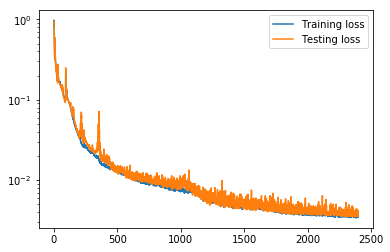

In [101]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 2400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()


def network_loss(output_gt,output_line_params):
        # Rule to apply:
        gt_a = -torch.sin(output_gt[:,0])
        gt_b = torch.cos(output_gt[:,0])
        gt_c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        
        gt_line_params = torch.stack((gt_a,gt_b,gt_c),dim=1)
        
#         # make the ground truth
#         c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
#         gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
    
        line_in_image = torch.abs(gt_c) < (torch.abs(gt_a) + torch.abs(gt_b))
    
        
        line_loss =  mse_loss(output_line_params*line_in_image.unsqueeze(1),gt_line_params*line_in_image.unsqueeze(1))
        
        beta = 2

        buffer_loss = torch.mean(~line_in_image*(torch.abs(torch.abs(output_line_params[:,2]) - beta*(torch.abs(output_line_params[:,0]) + torch.abs(output_line_params[:,1])))))
        
        loss = line_loss + buffer_loss
        
        return loss


    
    
for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(),lr=.0005) 
        
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        
        loss = network_loss(output_gt,output_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # forward pass to get outputs
            output_line_params = model(inputs)

            loss = network_loss(output_gt,output_line_params)

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(6.3922), tensor(6.4272), tensor(6.8365), tensor(6.3243), tensor(6.7834), tensor(6.8759), tensor(6.1763), tensor(6.5673), tensor(6.4362), tensor(6.9097), tensor(6.4249), tensor(6.9907), tensor(6.5946), tensor(6.2155), tensor(6.4405), tensor(6.4847), tensor(6.3340), tensor(6.6573), tensor(6.7629), tensor(6.8065), tensor(7.2265), tensor(6.4789), tensor(6.5453), tensor(6.5455), tensor(5.9374), tensor(6.5615), tensor(6.0846), tensor(6.3642), tensor(6.8834), tensor(6.4678), tensor(5.9604), tensor(6.4101), tensor(6.5789), tensor(6.8224), tensor(6.5968), tensor(6.8839), tensor(6.1376), tensor(7.3699)]


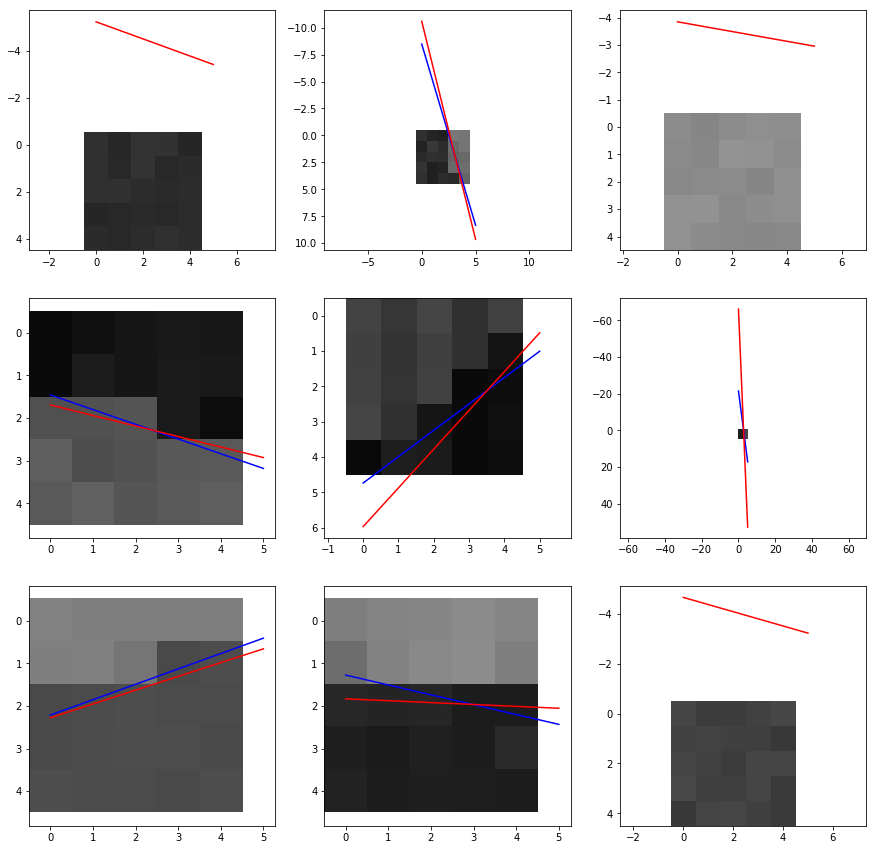

In [102]:
# Plot the Results

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)
    
    gt_a = -torch.sin(output_gt[:,0])
    gt_b = torch.cos(output_gt[:,0])
    gt_c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])

    gt_line_params = torch.stack((gt_a,gt_b,gt_c),dim=1)

    line_in_image = torch.abs(gt_c) < (torch.abs(gt_a) + torch.abs(gt_b))
    

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    plt.axis('equal')
    
    if line_in_image[ii]:
    # Plot the ground truth lines
        x_sample = torch.linspace(-1,1,inputs.shape[-1])
        y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]

        plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    
#     plt.xlim([0,W])
#     plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')




In [246]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 8, kernel_size=2) #64 is good
        self.conv2 = nn.Conv2d(8, 8, kernel_size=2)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=2)
        self.fc = nn.LazyLinear(2)
        self.activate = nn.ReLU()
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.activate(x)
        x = self.conv2(x)
        x = self.activate(x)
        x = self.conv3(x)
        x = self.activate(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
#         norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x#/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 8, 4, 4]              40
              ReLU-2              [-1, 8, 4, 4]               0
            Conv2d-3              [-1, 8, 3, 3]             264
              ReLU-4              [-1, 8, 3, 3]               0
            Conv2d-5              [-1, 8, 2, 2]             264
              ReLU-6              [-1, 8, 2, 2]               0
            Linear-7                    [-1, 2]              66
Total params: 634
Trainable params: 634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [257]:
# Now let's train the initial network with (cx,cy) loss

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 2400

mse_loss = nn.L1Loss()#nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 5:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
#         c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        
        cx = output_gt[:,2]*torch.sin(output_gt[:,0])
        cy = output_gt[:,2]*torch.cos(output_gt[:,0])
        
        gt_line_params = torch.stack((cx,cy),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            cx = torch.sin(output_gt[:,0])*output_gt[:,2] #-a*c where a = -sin(theta)
            cy = output_gt[:,2]*torch.cos(output_gt[:,0])

            gt_line_params = torch.stack((cx,cy),dim=1)

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

Epoch: 1, Avg. Train Loss: 8.582276429498897, Avg. Test Loss: 0.21660242974758148
Epoch: 2, Avg. Train Loss: 0.17780169178457822, Avg. Test Loss: 0.16427849233150482
Epoch: 3, Avg. Train Loss: 0.14506285760332557, Avg. Test Loss: 0.11953358352184296
Epoch: 4, Avg. Train Loss: 0.1164358138161547, Avg. Test Loss: 0.10819033533334732
Epoch: 5, Avg. Train Loss: 0.11077863609089571, Avg. Test Loss: 0.11496482789516449
Epoch: 6, Avg. Train Loss: 0.12573870920083102, Avg. Test Loss: 0.10071738064289093
Epoch: 7, Avg. Train Loss: 0.1000536594320746, Avg. Test Loss: 0.103860042989254
Epoch: 8, Avg. Train Loss: 0.10093484021285001, Avg. Test Loss: 0.09901266545057297
Epoch: 9, Avg. Train Loss: 0.09748960610698251, Avg. Test Loss: 0.10038728266954422
Epoch: 10, Avg. Train Loss: 0.09645514961551217, Avg. Test Loss: 0.09524437040090561
Epoch: 11, Avg. Train Loss: 0.09611489492304184, Avg. Test Loss: 0.09540602564811707
Epoch: 12, Avg. Train Loss: 0.09574447230381124, Avg. Test Loss: 0.0967458486557

Epoch: 98, Avg. Train Loss: 0.08768585438237471, Avg. Test Loss: 0.0873548835515976
Epoch: 99, Avg. Train Loss: 0.08694078484002282, Avg. Test Loss: 0.08682354539632797
Epoch: 100, Avg. Train Loss: 0.08715722727424959, Avg. Test Loss: 0.08799850195646286
Epoch: 101, Avg. Train Loss: 0.08699800477308385, Avg. Test Loss: 0.08744818717241287
Epoch: 102, Avg. Train Loss: 0.0868377100018894, Avg. Test Loss: 0.08803374320268631
Epoch: 103, Avg. Train Loss: 0.08742042604614707, Avg. Test Loss: 0.0873144119977951
Epoch: 104, Avg. Train Loss: 0.08683654376689126, Avg. Test Loss: 0.08709289133548737
Epoch: 105, Avg. Train Loss: 0.08679533705991857, Avg. Test Loss: 0.08728870004415512
Epoch: 106, Avg. Train Loss: 0.08677464057417476, Avg. Test Loss: 0.08835527300834656
Epoch: 107, Avg. Train Loss: 0.08680313317214741, Avg. Test Loss: 0.08774196356534958
Epoch: 108, Avg. Train Loss: 0.08672362329328762, Avg. Test Loss: 0.08704184740781784
Epoch: 109, Avg. Train Loss: 0.08682522098807728, Avg. Test

Epoch: 194, Avg. Train Loss: 0.08574639488669003, Avg. Test Loss: 0.08659208565950394
Epoch: 195, Avg. Train Loss: 0.08588250200538074, Avg. Test Loss: 0.085858054459095
Epoch: 196, Avg. Train Loss: 0.08582197340095744, Avg. Test Loss: 0.08623067289590836
Epoch: 197, Avg. Train Loss: 0.08581174235133564, Avg. Test Loss: 0.08649701625108719
Epoch: 198, Avg. Train Loss: 0.08582416229388293, Avg. Test Loss: 0.0860905572772026
Epoch: 199, Avg. Train Loss: 0.0856193251469556, Avg. Test Loss: 0.08698000758886337
Epoch: 200, Avg. Train Loss: 0.08563665703815572, Avg. Test Loss: 0.08580964058637619
Epoch: 201, Avg. Train Loss: 0.08556140932966681, Avg. Test Loss: 0.08598111569881439
Epoch: 202, Avg. Train Loss: 0.08556075148722704, Avg. Test Loss: 0.08619677275419235
Epoch: 203, Avg. Train Loss: 0.0856735481935389, Avg. Test Loss: 0.0864143818616867
Epoch: 204, Avg. Train Loss: 0.08562666037503411, Avg. Test Loss: 0.08631739765405655
Epoch: 205, Avg. Train Loss: 0.08578185588121415, Avg. Test 

KeyboardInterrupt: 

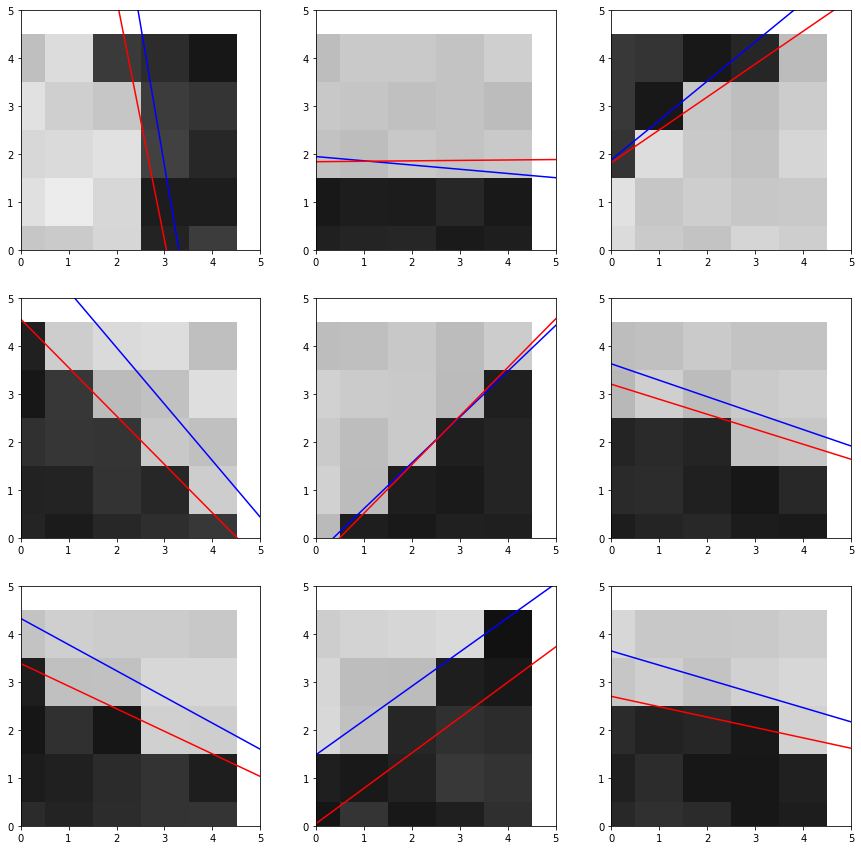

In [258]:
# Plot the Results

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    
        
    gt = output_gt.cpu().squeeze()
    
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),-output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])),axis=1).detach().cpu()
    
    
#     # Calculate angular loss
#     ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
#                                          ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

#     ang_loss_all.append(ang_loss)

    
    c = torch.sqrt(outputs[:,0]**2 + outputs[:,1]**2)
    
#     print(angle_params[0,2])
#     print(c[0])
    
    line_params = torch.stack((a,b,torch.sqrt(outputs[:,0]**2 + outputs[:,1]**2))).T



plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -line_params[ii,0]/line_params[ii,1]*x_sample - line_params[ii,2]/line_params[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')




[tensor(3.2657), tensor(3.1201), tensor(3.0416), tensor(3.1251), tensor(3.2778), tensor(3.0401), tensor(3.0226), tensor(3.2283), tensor(3.1112), tensor(3.1211), tensor(3.2069), tensor(3.2089), tensor(3.0163), tensor(3.0267), tensor(3.1548), tensor(3.0471), tensor(3.2013), tensor(3.2747), tensor(3.1818), tensor(3.1274), tensor(3.2289), tensor(3.1901), tensor(3.2355), tensor(3.3059), tensor(3.2029), tensor(3.1610), tensor(3.3373), tensor(3.1394), tensor(3.1852), tensor(3.1662)]


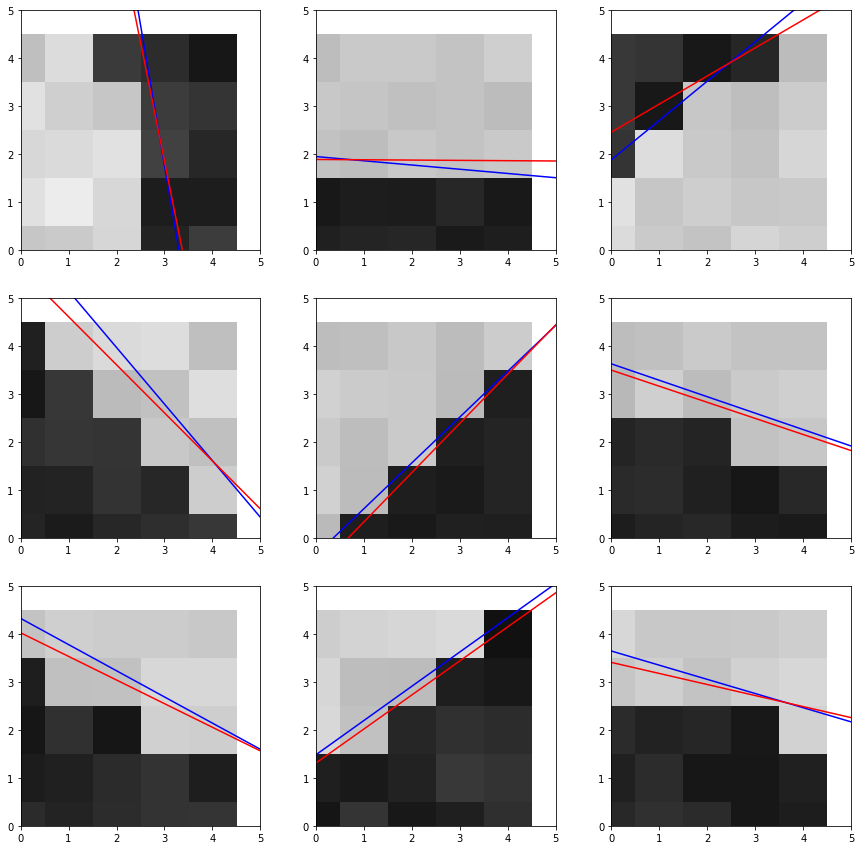

In [42]:
# Plot the Results

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')



In [ ]:
# %load_ext autoreload
# %reload_ext autoreload

In [105]:
class offCenterLineNetBig(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2) #64 is good
        self.conv2 = nn.Conv2d(16, 16, kernel_size=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=2)
        self.conv4 = nn.Conv2d(32, 3, kernel_size=2)
#         self.avgpool = nn.AvgPool2d(2)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(128)
    
    def forward(self, x):
        
#         mean, std = torch.mean(x), torch.std(x)
#         x  = (x-mean)/std
        
        x = self.conv1(x)
        x = self.activate(x)
        x = self.conv2(x)
        x = self.activate(x)
        x = self.conv3(x)
        x = self.activate(x)
        x = self.conv4(x)
        
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2,:,:],p=2,dim=1)).unsqueeze(1)    
        out = x/(norm_factor)#+eps)

        return out
    
R = 32 

big_model = offCenterLineNetBig()
big_model = big_model.to(dev)
summary(big_model, input_size=(1, R, R))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 31, 31]              80
              ReLU-2           [-1, 16, 31, 31]               0
            Conv2d-3           [-1, 16, 30, 30]           1,040
              ReLU-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 32, 29, 29]           2,080
              ReLU-6           [-1, 32, 29, 29]               0
            Conv2d-7            [-1, 3, 28, 28]             387
Total params: 3,587
Trainable params: 3,587
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.88
Params size (MB): 0.01
Estimated Total Size (MB): 0.90
----------------------------------------------------------------


In [399]:
# for name, child in model.named_children():
#             for name2, params in child.named_parameters():
#                 print(name, name2)
                
# for name, child in big_model.named_children():
#             for name2, params in child.named_parameters():
#                 print(name, name2)
                

In [106]:
# Copy weights to the new network

offCenterLineNetWeights = model.state_dict()
offCenterLineNetWeightsBig = big_model.state_dict()

with torch.no_grad():
    big_model.conv1.weight.copy_(offCenterLineNetWeights['conv1.weight'])
    big_model.conv1.bias.copy_(offCenterLineNetWeights['conv1.bias'])
    big_model.conv2.weight.copy_(offCenterLineNetWeights['conv2.weight'])
    big_model.conv2.bias.copy_(offCenterLineNetWeights['conv2.bias'])
    big_model.conv3.weight.copy_(offCenterLineNetWeights['conv3.weight'])
    big_model.conv3.bias.copy_(offCenterLineNetWeights['conv3.bias'])
    big_model.conv4.weight.copy_(offCenterLineNetWeights['fc.weight'].view(offCenterLineNetWeightsBig['conv4.weight'].shape))
    big_model.conv4.bias.copy_(offCenterLineNetWeights['fc.bias'])
    

In [463]:
# # Verify that the model outputs are the same when the input size is the patch size

# c = -params[:,2]*torch.cos(params[:,0]) + params[:,1]*torch.sin(params[:,0])
# gt_params = torch.stack((-torch.sin(params[:,0]),torch.cos(params[:,0]),c),axis=1).detach().cpu()
    
# print(gt_params)    

# print(big_model(wedges_grey).cpu().detach())
# print(model(wedges_grey).cpu().detach())

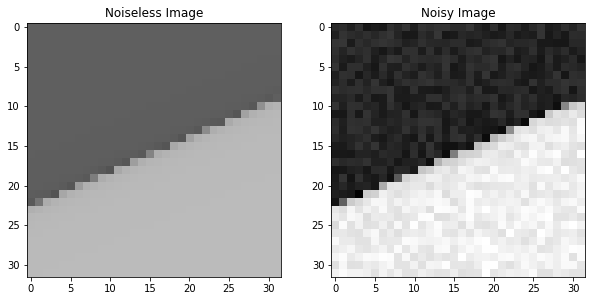

In [137]:
# Extract the network weights and process on a larger image:

# First produce a larger image:

R = 32
add_noise = 1
centered = 0
random_colors = 1
num_samples = 1

dists,wedges,boundaries,params = make_random_line_set(num_samples,R,'cpu',centered)

grey_transform = make_grey_transform(num_samples,wedges,'cpu',random_colors).unsqueeze(-1).unsqueeze(-1)

wedges_grey_noiseless = (wedges[:,:2,:,:,:,:]*grey_transform).sum(1).squeeze(1)

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(wedges_grey_noiseless.squeeze(),cmap='gray', vmin=0, vmax=1)
plt.title('Noiseless Image')

wedges_grey = wedges_grey_noiseless.clone()

if add_noise:
    wedges_grey = wedges_grey_noiseless + .5*torch.rand(num_samples).unsqueeze(1).unsqueeze(1).unsqueeze(1)*torch.rand(*wedges_grey.shape,device='cpu')
    mn, mx = wedges_grey.min(), wedges_grey.max()

    # Adjust contrast (equally to both images)
    wedges_grey = (wedges_grey - mn) / (mx - mn) 

plt.subplot(122)
plt.imshow(wedges_grey.squeeze(),cmap='gray', vmin=0, vmax=1)
plt.title('Noisy Image')

# print(params,torch.rad2deg(params[0,0,0,0]))

wedges_grey = wedges_grey.to(dev)

In [138]:
# Make Transformation matrix L

# Each patch needs to be transformed by a different 3 x 3 transformation
# Assuming zero-padding, the output of the network will 64 x 64 x 3
# The transformation will be 64 x 64 x 3 x 3
# Hence, we need to add an additional input to the dimension to make it: 64 x 64 x 1 x 3

num_convs = 2
Wn,Hn = big_model(wedges_grey).shape[-1],big_model(wedges_grey).shape[-1]


# First define the center of the global coordinate system
xa,ya = torch.zeros((Wn,Hn),device='cpu'),torch.zeros((Wn,Hn),device='cpu')

# First, let's make the transformation matrix:
y0, x0 = torch.meshgrid([torch.linspace(-1.0+num_convs/W, 1.0-num_convs/W, Wn, device='cpu'),
                               torch.linspace(-1.0+num_convs/H, 1.0-num_convs/H, Hn, device='cpu')])

L = torch.zeros((1,3,3,Hn,Wn),device='cpu')#torch.tensor([[1-x0,0,0],[0,1-y0,0],[0,0,1]])
L[:,0,0,:,:] = 1
L[:,1,1,:,:] = 1
L[:,2,2,:,:] = 1
L[:,0,2,:,:] = -x0+xa
L[:,1,2,:,:] = -y0+ya

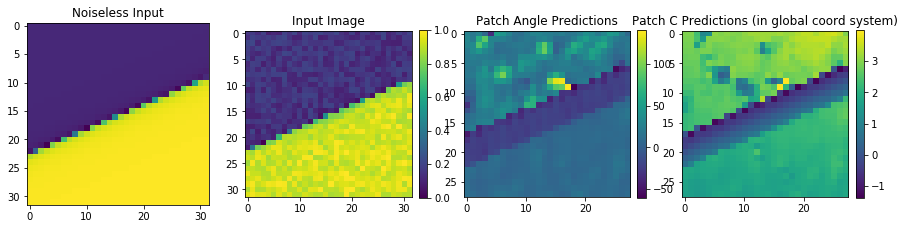

In [139]:
# wedges_grey = wedges_grey.to(dev)

output_line_params = big_model(wedges_grey).cpu().detach()

# I need to transform this into a global coordinate system

# transform each patch into global coordinate system
output_line_params_T = torch.einsum('ajbc,ajkbc->akbc',output_line_params,L)

# output_line_params_plot = output_line_params_trans.clone() + 1
# output_line_params_plot = output_line_params_plot/torch.max(output_line_params_plot)

output_line_angles = torch.rad2deg(torch.atan2(-output_line_params[0,0,:,:],output_line_params[0,1,:,:]))
output_line_disp = output_line_params_T[0,2,:,:]


# x_sample = torch.linspace(-1,1,R)
# y_sample = -gt_params[0,0,0,0]/gt_params[0,1,0,0]*x_sample - gt_params[0,2,0,0]/gt_params[0,1,0,0]

plt.figure(figsize=[15,15])
plt.subplot(141)
plt.imshow(wedges_grey_noiseless.squeeze())
plt.title('Noiseless Input')
# plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'r')
plt.subplot(142)
plt.imshow(wedges_grey.cpu().squeeze())
# plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'r')
plt.title('Input Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(143)
plt.imshow(output_line_angles)
plt.title('Patch Angle Predictions')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(144)
plt.imshow(output_line_disp)
plt.title('Patch C Predictions (in global coord system)')
plt.colorbar(fraction=0.046, pad=0.04)


Text(0.5, 1.0, 'Parameter Error')

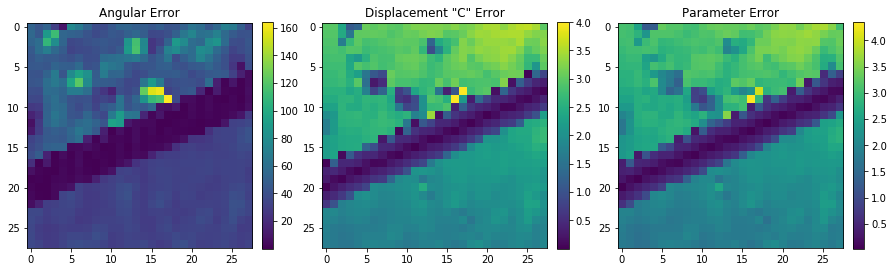

In [140]:
c = -params[:,2]*torch.cos(params[:,0]) + params[:,1]*torch.sin(params[:,0])
gt_params = torch.stack((-torch.sin(params[:,0]),torch.cos(params[:,0]),c),axis=1).detach().cpu()
    

# Calculate angular loss
ang_loss = torch.abs(torch.rad2deg(torch.atan2(-gt_params[:,0]*output_line_params_T[:,1] + gt_params[:,1]*output_line_params_T[:,0]
                                     ,gt_params[:,1]*output_line_params_T[:,1]+gt_params[:,0]*output_line_params_T[:,0]).cpu())).squeeze()

    
plt.figure(figsize=[15,15])
plt.subplot(131)
plt.imshow(ang_loss)
plt.title('Angular Error')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(torch.abs(c-output_line_params_T[:,2]).squeeze())
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Displacement "C" Error')
plt.subplot(133)
plt.imshow(torch.norm(output_line_params_T-gt_params,dim=1).squeeze())
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Parameter Error')


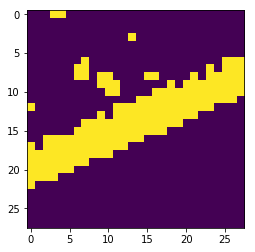

In [141]:
# Check for which patches satisfy inequality

# First convert to (cx,cy)
# cx,cy = -output_line_params[0,0,:,:]*output_line_params[0,2,:,:],output_line_params[0,1,:,:]*output_line_params[0,2,:,:]

# check_patches = (torch.abs(cy*output_line_params[0,1,:,:]) + torch.abs(cx*output_line_params[0,0,:,:])) < (torch.abs(output_line_params[0,0,:,:]) + torch.abs(output_line_params[0,1,:,:]))
check_patches = (torch.abs(output_line_params[0,0,:,:]) + torch.abs(output_line_params[0,1,:,:])) > torch.abs(output_line_params[0,2,:,:])


plt.figure()
plt.imshow(check_patches)



gt C= tensor([[[0.1765]]])
mode C= tensor(0.0058)
gt angle= tensor([[73.0240]])
mode angle= tensor(65.5056)


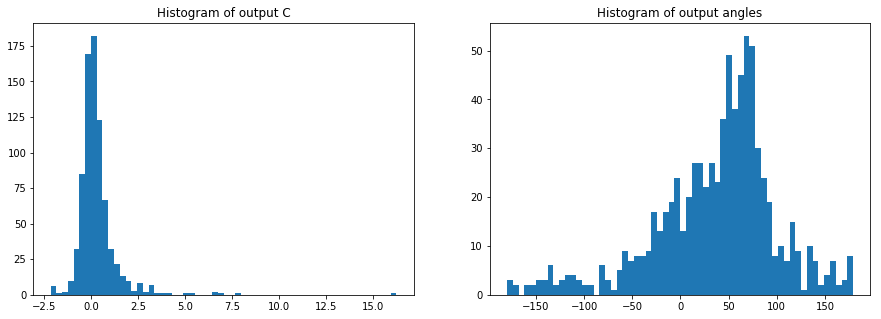

In [121]:
# Make C histogram

plt.figure(figsize=[15,5])
plt.subplot(121)
plt.hist(output_line_params_T.squeeze()[2,:,:].ravel(),bins=60);
plt.title('Histogram of output C')

print('gt C=',c)
# print('center C=',output_line_disp[16,16])

weight=torch.histogram(output_line_params_T.ravel(), bins=60)
print('mode C=',weight[1][torch.argmax(weight[0])])


# Next, angles:

plt.subplot(122)
plt.hist(output_line_angles.ravel(),bins=60)
plt.title('Histogram of output angles')

print('gt angle=',torch.rad2deg(params[0][0]))
# print('center angle=',output_line_angles[16,16])

weight=torch.histogram(output_line_angles.ravel(), bins=60)
print('mode angle=',weight[1][torch.argmax(weight[0])])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 26, 26])


Text(0.5, 1.0, 'Variance of C Clipped')

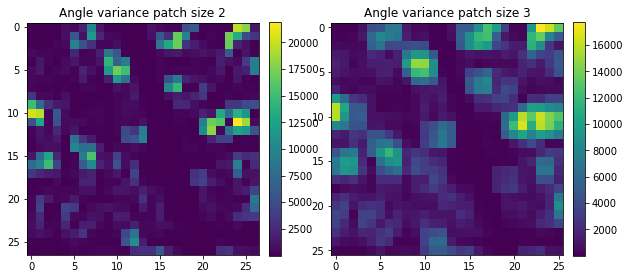

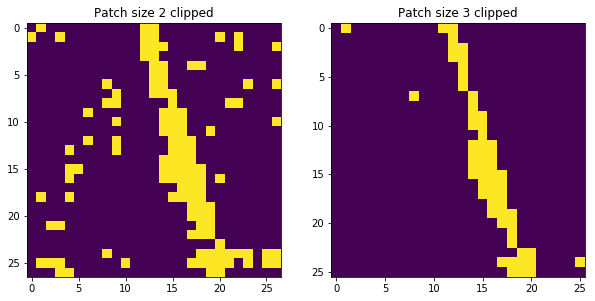

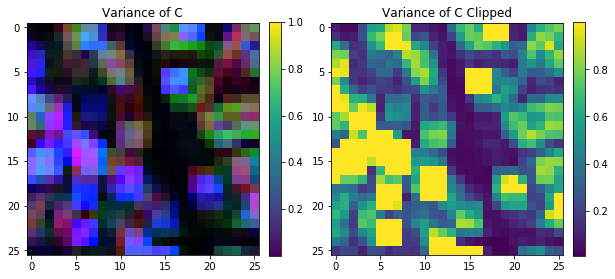

In [122]:
# Calculate patch variance of output line_angles

ker_size = 2

running_var = F.avg_pool2d(output_line_angles.unsqueeze(0)**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_angles.unsqueeze(0), kernel_size=ker_size,stride=1)**2

ker_size = 3

running_var_2 = F.avg_pool2d(output_line_angles.unsqueeze(0)**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_angles.unsqueeze(0), kernel_size=ker_size,stride=1)**2

plt.figure(figsize=[10,10])
plt.title('Variance of Angles')
plt.subplot(121)
plt.imshow(running_var.squeeze())
plt.title('Angle variance patch size 2')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(running_var_2.squeeze())
plt.title('Angle variance patch size 3')
plt.colorbar(fraction=0.046, pad=0.04)

plt.figure(figsize=[10,10])
plt.subplot(121)
low_var = running_var.squeeze()<50
low_var_2 = running_var_2.squeeze()<100

plt.imshow(low_var)
plt.title('Patch size 2 clipped')
plt.subplot(122)
plt.imshow(low_var_2)
plt.title('Patch size 3 clipped')
# plt.colorbar()


# Figure out why this visualization is so good

ker_size = 3

running_var = F.avg_pool2d(output_line_params_T**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_params_T, kernel_size=ker_size,stride=1)**2
m = nn.Threshold(1, 1)

print(running_var.shape)


plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(running_var.squeeze().permute(1,2,0))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Variance of C')
# plt.figure(figsize=[15,15])
plt.subplot(122)
plt.imshow(np.clip(torch.linalg.norm(running_var.squeeze().permute(1,2,0),dim=2),0,1))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Variance of C Clipped')


# plt.figure(figsize=[15,15])
# plt.subplot(131)
# plt.imshow(running_var.squeeze()[0])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(132)
# plt.imshow(running_var.squeeze()[1])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(133)
# plt.imshow(m(running_var.squeeze()[2]))
# plt.colorbar(fraction=0.046, pad=0.04)

# plt.subplot(122)
# plt.imshow(running_var_2.squeeze())
# plt.colorbar(fraction=0.046, pad=0.04)

# plt.subplot(122)
# low_var = running_var.squeeze()<500

# plt.imshow(low_var.permute(1,2,0))




torch.Size([1, 3, 28, 28])
torch.Size([28, 28])
torch.Size([1, 1, 32, 32])


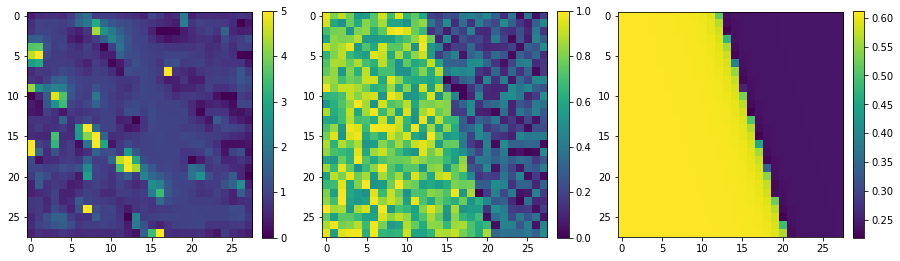

In [123]:
# How diffferent is each patch from its neighborhood of patches:

ker_size = 3
avg_patch_params = F.avg_pool2d(output_line_params_T, kernel_size=ker_size, stride=1, padding=(1,1))


dot_prod = torch.sum(avg_patch_params*output_line_params_T,1).squeeze()

print(output_line_params_T.shape)
print(dot_prod.shape)
print(wedges_grey.shape)

x_sample = torch.linspace(-1,1,8)
y_sample = -gt_params[0,0,0,0]/gt_params[0,1,0,0]*x_sample - gt_params[0,2,0,0]/gt_params[0,1,0,0]

plt.figure(figsize=[15,15])
plt.subplot(131)
plt.imshow(dot_prod)
plt.imshow(np.clip(dot_prod,0,5))
# plt.plot(x_sample*R/2+R/2,y_sample*R/2+R/2,'r')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(wedges_grey.cpu().detach().squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow(wedges_grey_noiseless.cpu().squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)
# plt.plot(x_sample*R/2+R/2,y_sample*R/2+R/2,'r')

# Measure how different 

torch.Size([1, 3, 28, 28])
torch.Size([1, 3, 28, 28])


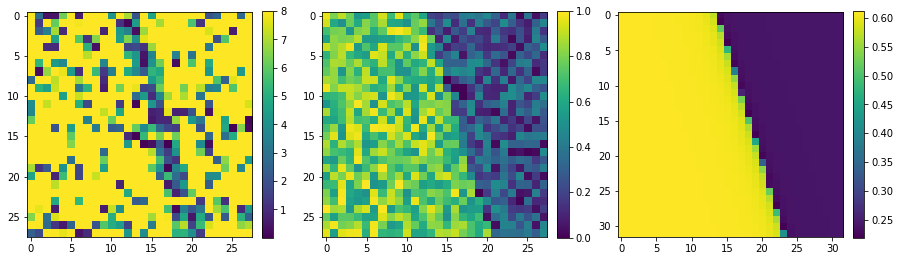

In [124]:
# How diffferent is each patch angle from its neighborhood of patches:

ker_size = 3
avg_angle_param = F.avg_pool2d(output_line_params_T, kernel_size=ker_size, stride=1, padding=(1,1))

print(avg_angle_param.shape)
print(output_line_params_T.shape)

# Calculate angular loss
ang_diff = torch.abs(torch.rad2deg(torch.atan2(-avg_angle_param[:,0,:,:]*output_line_params_T[:,1,:,:] + avg_angle_param[:,1,:,:]*output_line_params_T[:,0,:,:]
                                     ,avg_angle_param[:,1,:,:]*output_line_params_T[:,1,:,:]+avg_angle_param[:,0,:,:]*output_line_params_T[:,0,:,:]).cpu())).squeeze()


x_sample = torch.linspace(-1,1,8)
y_sample = -gt_params[0,0,0,0]/gt_params[0,1,0,0]*x_sample - gt_params[0,2,0,0]/gt_params[0,1,0,0]


plt.figure(figsize=[15,15])
plt.subplot(131)
# plt.imshow(dot_prod)
plt.imshow(ang_diff)
plt.imshow(np.clip(ang_diff,0,8))
# plt.plot(x_sample*R/2+R/2,y_sample*R/2+R/2,'r')
# plt.xlim([0,W])
# plt.ylim(([0,W]))
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(wedges_grey.cpu().detach().squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.imshow(wedges_grey_noiseless.cpu().squeeze())
plt.colorbar(fraction=0.046, pad=0.04)


# Plot the ground truth lines

# plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'r')
# plt.xlim([0,W])
# plt.ylim(([0,W]))


    
# Measure how different 


In [125]:
def make_random_junction_set(num_samples,img_size,opts,dev,eta=.01,delta=.02):

#     img_size = 64
    img = np.zeros((img_size,img_size,1))

    opts.R                        = img_size
    opts.stride                   = img_size
    opts.eta                      = 0.01
    opts.delta                    = 0.02
    opts.lr_angles                = 0.003
    opts.lr_x0y0                  = 0.03
    opts.lambda_boundary_final    = 0.5
    opts.lambda_color_final       = 0.1
    opts.nvals                    = 31
    opts.num_initialization_iters = 30
    opts.num_refinement_iters     = 1000
    opts.greedy_step_every_iters  = 50
    opts.parallel_mode            = True

#     dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    foj = FieldOfJunctions(img, dev, opts)

    # Bounds of image: [-1,1],[-1,1]
    # Randomly generate junction location from [-3,3],[3,3] and 3 angles between [0,2*pi]

#     jcenter = 2*torch.rand(num_samples,2) - 1
#     jangles = 2*np.pi*torch.rand(num_samples,3) - np.pi
    jangles = 2*np.pi*torch.rand(num_samples,3).to(dev)
#     jcenter = .9*torch.rand(num_samples,2).to(device) - .9
    jcenter = (.2*torch.rand(num_samples,2) - .2).to(dev)
    params = torch.cat([jangles,jcenter],dim=1).unsqueeze(2).unsqueeze(3)
    
    dists = foj.params2dists(params)
    wedges = foj.dists2indicators(dists).squeeze(-1).squeeze(-1)

    params = params
    
    print(wedges.shape)
    
    return dists,wedges,params,foj


def make_grey_transform_junc(num_images,dev,opt=0):
    
    if opt == 0:
        return torch.tensor([0,.5,1]).unsqueeze(0).unsqueeze(2).unsqueeze(2)

    if opt == 1:  

        grey_transform = torch.zeros((wedges.shape[0],3,1,1),device=dev)

        num_grey_schemes = 0
        while num_grey_schemes<wedges.shape[0]:
            
            sample = torch.rand(3,device=dev).sort()[0]

            if torch.max(torch.diff(sample))<.2:
                continue

            grey_transform[num_grey_schemes,:,:,:] = sample.unsqueeze(1).unsqueeze(1)

            num_grey_schemes += 1

        return grey_transform

torch.Size([1, 3, 32, 32])
tensor([[[[0.0068]],

         [[0.4238]],

         [[0.6921]]]])


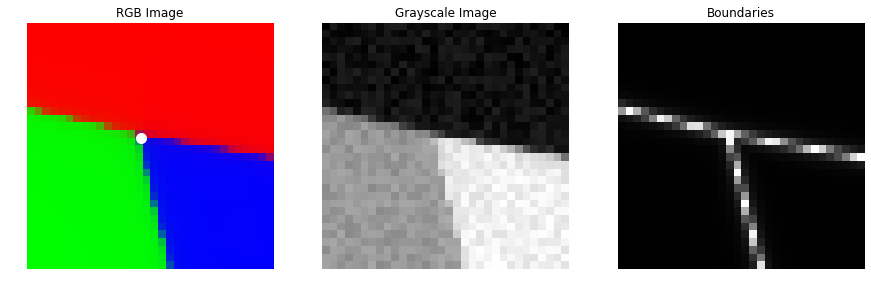

In [126]:
# Produce a junction image

R = 32
add_noise = 1


opts = SimpleNamespace()
dists,wedges,params,foj = make_random_junction_set(1,R,opts,'cpu')

grey_transform = make_grey_transform_junc(wedges.shape[0],'cpu',opt=1)

print(grey_transform)

wedges_grey = (wedges*grey_transform).sum(1)
boundaries = foj.dists2boundaries(dists).squeeze(1).squeeze(3).squeeze(3)

if add_noise:
    wedges_grey = wedges_grey + .2*torch.rand(num_samples,device='cpu').unsqueeze(1).unsqueeze(1).unsqueeze(1)*torch.rand(*wedges_grey.shape,device='cpu')
    mn, mx = wedges_grey.min(), wedges_grey.max()

    # Adjust contrast (equally to both images)
    wedges_grey = (wedges_grey - mn) / (mx - mn) 


img_show = 0

# TO DO: figure out how to plot the junction center!!
junction_center = (params[img_show,-2:,:,:].squeeze()*R/2 + R/2).cpu()

# print(junction_center)


plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].permute(1,2,0))
plt.plot(junction_center[0],junction_center[1],'wo',markersize=10)
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze(),cmap='gray',vmin=0,vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze(),cmap='gray',vmin=0,vmax=1)
plt.title('Boundaries')
plt.axis('off');

wedges_grey = wedges_grey.to(dev)#.unsqueeze(0)


In [127]:
# Make Transformation matrix L

# Each patch needs to be transformed by a different 3 x 3 transformation
# Assuming zero-padding, the output of the network will 64 x 64 x 3
# The transformation will be 64 x 64 x 3 x 3
# Hence, we need to add an additional input to the dimension to make it: 64 x 64 x 1 x 3

num_convs = 2
Wn,Hn = big_model(wedges_grey).shape[-1],big_model(wedges_grey).shape[-1]


# First define the center of the global coordinate system
xa,ya = torch.zeros((Wn,Hn),device='cpu'),torch.zeros((Wn,Hn),device='cpu')

# First, let's make the transformation matrix:
y0, x0 = torch.meshgrid([torch.linspace(-1.0+num_convs/W, 1.0-num_convs/W, Wn, device='cpu'),
                               torch.linspace(-1.0+num_convs/H, 1.0-num_convs/H, Hn, device='cpu')])

L = torch.zeros((1,3,3,Hn,Wn),device='cpu')#torch.tensor([[1-x0,0,0],[0,1-y0,0],[0,0,1]])
L[:,0,0,:,:] = 1
L[:,1,1,:,:] = 1
L[:,2,2,:,:] = 1
L[:,0,2,:,:] = -x0+xa
L[:,1,2,:,:] = -y0+ya


torch.Size([1, 3, 28, 28])


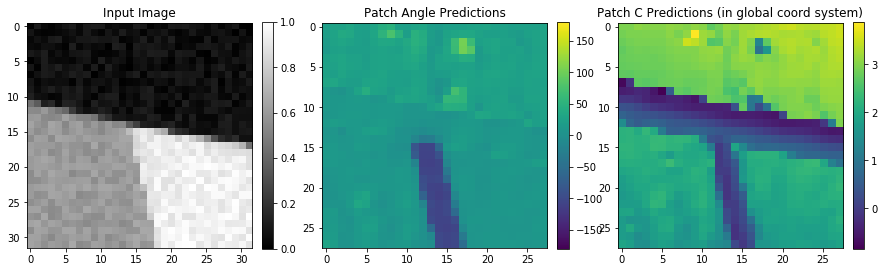

In [128]:
output_line_params = big_model(wedges_grey).cpu().detach()

print(output_line_params.shape)

# I need to transform this into a global coordinate system

# transform each patch into global coordinate system
output_line_params_T = torch.einsum('ajbc,ajkbc->akbc',output_line_params,L)

# output_line_params_plot = output_line_params_trans.clone() + 1
# output_line_params_plot = output_line_params_plot/torch.max(output_line_params_plot)

output_line_angles = torch.rad2deg(torch.atan2(-output_line_params[0,0,:,:],output_line_params[0,1,:,:]))
output_line_disp = output_line_params_T[0,2,:,:]


plt.figure(figsize=[15,15])
plt.subplot(131)
plt.imshow(wedges_grey.cpu().detach().squeeze(),cmap='gray',vmin=0,vmax=1)
plt.title('Input Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(output_line_angles,vmin=-180,vmax=180)
plt.title('Patch Angle Predictions')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow(output_line_disp)
plt.title('Patch C Predictions (in global coord system)')
plt.colorbar(fraction=0.046, pad=0.04)


In [311]:
# # Issue: not enough separation of color

# # What if we normalizae the input image first

# input_img = wedges_grey[:,:,:10,15:25]

# # mean, std, var = torch.mean(input_img), torch.std(input_img), torch.var(input_img)

# # input_img = (input_img-mean)/std

# output_line_params = big_model(input_img).cpu().detach()

# print(output_line_params.shape)

# # I need to transform this into a global coordinate system

# # transform each patch into global coordinate system
# output_line_params_T = output_line_params#torch.einsum('ajbc,ajkbc->akbc',output_line_params,L)

# # output_line_params_plot = output_line_params_trans.clone() + 1
# # output_line_params_plot = output_line_params_plot/torch.max(output_line_params_plot)

# output_line_angles = torch.rad2deg(torch.atan2(-output_line_params[0,0,:,:],output_line_params[0,1,:,:]))
# output_line_disp = output_line_params_T[0,2,:,:]


# plt.figure(figsize=[15,15])
# plt.subplot(131)
# plt.imshow(input_img.cpu().detach().squeeze())
# plt.title('Input Image')
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(132)
# plt.imshow(output_line_angles,vmin=-180,vmax=180)
# plt.title('Patch Angle Predictions')
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(133)
# plt.imshow(output_line_disp)
# plt.title('Patch C Predictions (in global coord system)')
# plt.colorbar(fraction=0.046, pad=0.04)





tensor([-0.4269,  0.9043,  2.9680])
tensor([-0.4483,  0.8939,  2.9546])
torch.Size([1, 3, 28, 28])
tensor([-0.4269,  0.9043,  2.9680])


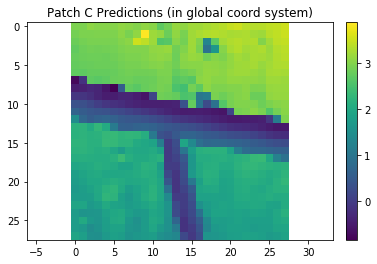

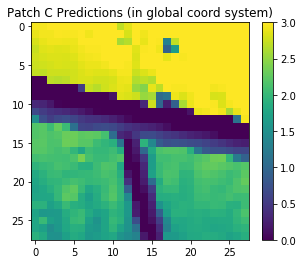

In [130]:
R = 32

line_test = output_line_params_T[0,:,5,12]

print(output_line_params_T[0,:,5,12])
print(output_line_params_T[0,:,6,12])

x_sample = torch.linspace(-1,1,8)
y_sample = -line_test[0]/line_test[1]*x_sample - line_test[2]/line_test[1]


plt.figure()
plt.imshow(output_line_disp)
# plt.plot(5,12,'rx')
# plt.plot(x_sample*R/2+R/2,y_sample*R/2+R/2,'r')
plt.title('Patch C Predictions (in global coord system)')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('equal')


print(output_line_params.shape)
print(line_test)

plt.figure()
plt.imshow(np.clip(output_line_disp,0,3))
plt.title('Patch C Predictions (in global coord system)')
plt.colorbar(fraction=0.046, pad=0.04)

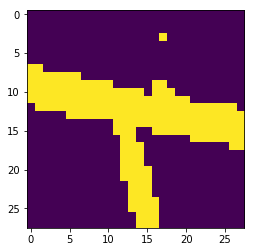

In [136]:
check_patches = (torch.abs(output_line_params[0,0,:,:]) + torch.abs(output_line_params[0,1,:,:])) > torch.abs(output_line_params[0,2,:,:])


plt.figure()
plt.imshow(check_patches)

# c = output_line_params[0,2,:,:]
# a = output_line_params[0,0,:,:]
# b = output_line_params[0,1,:,:]

# plot1 =  torch.abs(c) < (torch.abs(a + b))
# plot2 = torch.abs(c) < (torch.abs(a - b))

# plt.figure()
# plt.subplot(121)
# plt.imshow(plot1, extent=[-2,2,-2,2])
# plt.plot(1,1,'rx')
# plt.subplot(122)
# plt.imshow(plot2, extent=[-2,2,-2,2])
# plt.plot(1,1,'rx')

# plt.figure()
# plt.imshow(torch.abs(a - b), extent=[-2,2,-2,2])
# plt.plot(1,1,'rx')

# plt.figure(figsize=[15,15])
# plt.subplot(131)
# plt.imshow(torch.abs(a + b), extent=[-2,2,-2,2])
# plt.subplot(132)
# plt.imshow(torch.abs(a - b), extent=[-2,2,-2,2])
# plt.subplot(133)
# plt.imshow(torch.abs(a)+torch.abs(b), extent=[-2,2,-2,2])




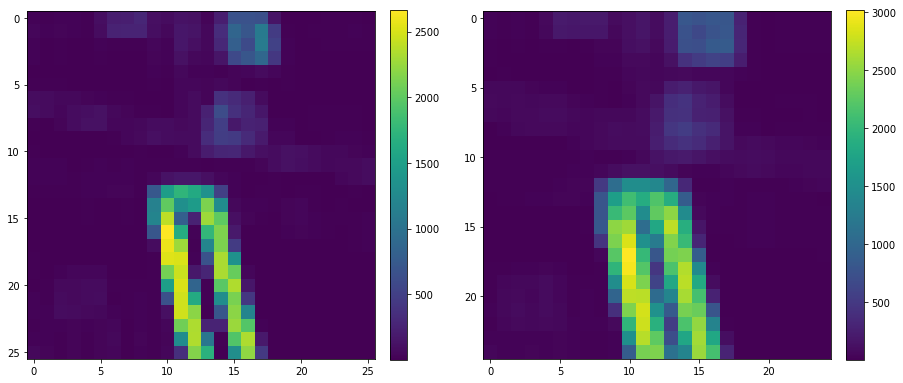

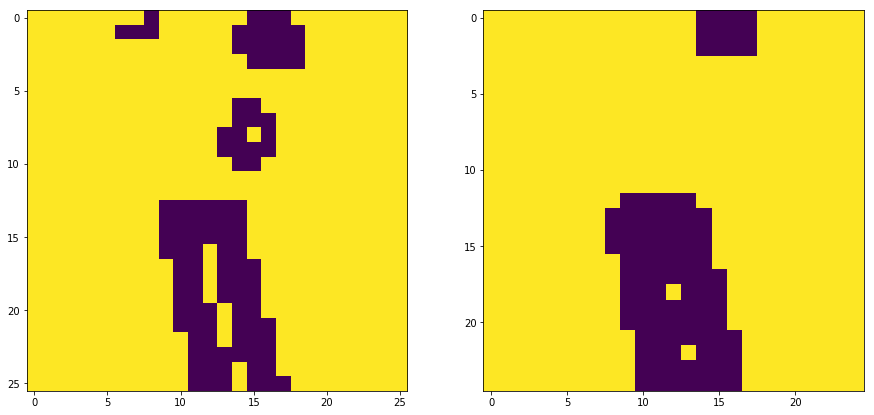

In [132]:
ker_size = 3

running_var = F.avg_pool2d(output_line_angles.unsqueeze(0)**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_angles.unsqueeze(0), kernel_size=ker_size,stride=1)**2

ker_size = 4

running_var_2 = F.avg_pool2d(output_line_angles.unsqueeze(0)**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_angles.unsqueeze(0), kernel_size=ker_size,stride=1)**2

plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(running_var.squeeze())
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(running_var_2.squeeze())
plt.colorbar(fraction=0.046, pad=0.04)

plt.figure(figsize=[15,15])
plt.subplot(121)

low_var = running_var.squeeze()<250
low_var_2 = running_var_2.squeeze()<600

plt.imshow(low_var)
plt.subplot(122)
plt.imshow(low_var_2)
# plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 26, 26])


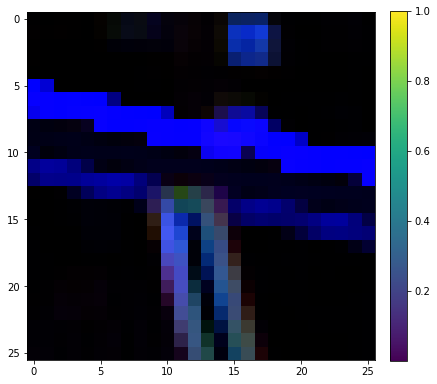

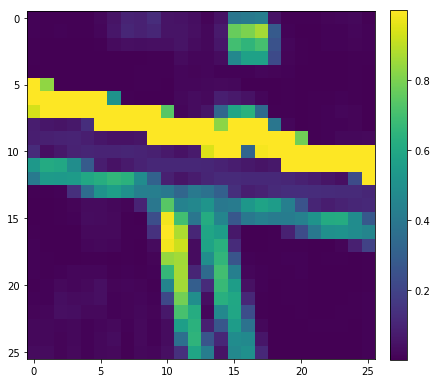

In [133]:
# Visualize variance

ker_size = 3

running_var = F.avg_pool2d(output_line_params_T**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_params_T, kernel_size=ker_size,stride=1)**2
m = nn.Threshold(1, 1)

print(running_var.shape)


plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(running_var.squeeze().permute(1,2,0))
plt.colorbar(fraction=0.046, pad=0.04)

plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(np.clip(torch.linalg.norm(running_var.squeeze().permute(1,2,0),dim=2),0,1))
plt.colorbar(fraction=0.046, pad=0.04)

# plt.figure(figsize=[15,15])
# plt.subplot(131)
# plt.imshow(running_var.squeeze()[0])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(132)
# plt.imshow(running_var.squeeze()[1])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(133)
# plt.imshow(m(running_var.squeeze()[2]))
# plt.colorbar(fraction=0.046, pad=0.04)

# plt.subplot(122)
# plt.imshow(running_var_2.squeeze())
# plt.colorbar(fraction=0.046, pad=0.04)

# plt.subplot(122)
# low_var = running_var.squeeze()<500

# plt.imshow(low_var.permute(1,2,0))



torch.Size([1, 3, 28, 28])
torch.Size([28, 28])
torch.Size([1, 1, 32, 32])


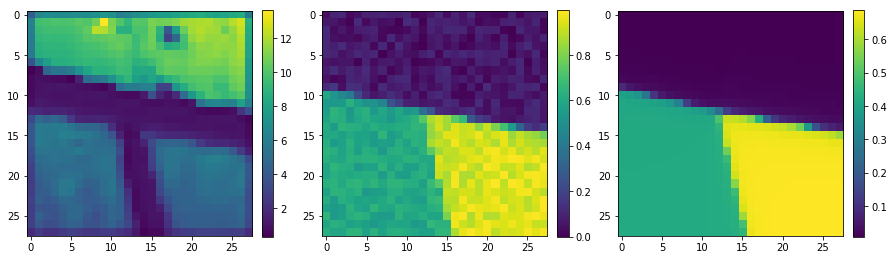

In [134]:
# How diffferent is each patch from its neighborhood of patches:

ker_size = 3
avg_patch_params = F.avg_pool2d(output_line_params_T, kernel_size=ker_size, stride=1, padding=(1,1))


dot_prod = torch.sum(avg_patch_params*output_line_params_T,1).squeeze()

print(output_line_params_T.shape)
print(dot_prod.shape)
print(wedges_grey.shape)

plt.figure(figsize=[15,15])
plt.subplot(131)
plt.imshow(dot_prod)
plt.imshow(np.clip(dot_prod,0,20))
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(wedges_grey.cpu().detach().squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow((wedges*grey_transform).sum(1).squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)

# Measure how different 

torch.Size([1, 3, 28, 28])
torch.Size([28, 28])
torch.Size([1, 1, 32, 32])


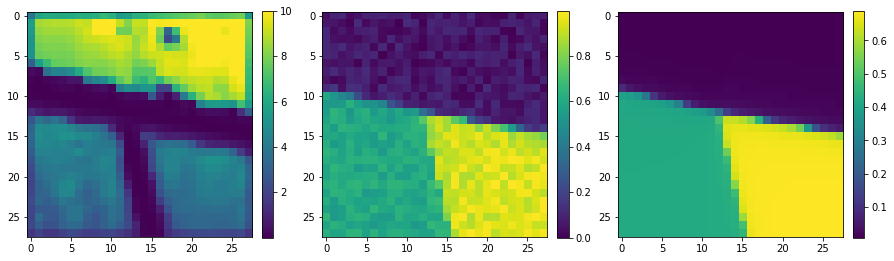

In [135]:
# How diffferent is each patch angle from its neighborhood of patches:

ker_size = 3
avg_patch_params = F.avg_pool2d(output_line_params_T, kernel_size=ker_size, stride=1, padding=(1,1))


#dot_prod = torch.sum(avg_patch_params[:,:2,:,:]*output_line_params_T[:,:2,:,:],1).squeeze()

dot_prod = torch.abs(avg_patch_params[:,2,:,:]*output_line_params_T[:,2,:,:]).squeeze()

print(output_line_params_T.shape)
print(dot_prod.shape)
print(wedges_grey.shape)

plt.figure(figsize=[15,15])
plt.subplot(131)
# plt.imshow(dot_prod)
plt.imshow(np.clip(dot_prod,0,10))
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(wedges_grey.cpu().detach().squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow((wedges*grey_transform).sum(1).squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)

# Measure how different 

In [121]:
# Use inlier/outlier based on variance 

def intersect(P0,P1):
    """P0 and P1 are NxD arrays defining N lines.
    D is the dimension of the space. This function 
    returns the least squares intersection of the N
    lines from the system given by eq. 13 in 
    http://cal.cs.illinois.edu/~johannes/research/LS_line_intersect.pdf.
    """
    # generate all line direction vectors 
    n = (P1-P0)/np.linalg.norm(P1-P0,axis=1)[:,np.newaxis] # normalized

    # generate the array of all projectors 
    projs = np.eye(n.shape[1]) - n[:,:,np.newaxis]*n[:,np.newaxis]  # I - n*n.T
    # see fig. 1 

    # generate R matrix and q vector
    R = projs.sum(axis=0)
    q = (projs @ P0[:,:,np.newaxis]).sum(axis=0)

    # solve the least squares problem for the 
    # intersection point p: Rp = q
    p = np.linalg.lstsq(R,q,rcond=None)[0]

    return p



In [ ]:
p = intersect

tensor([[[[-0.8851,  0.4653, -0.1441]]]])
tensor([[[[-0.6472,  0.7624, -0.0786]]]])
tensor([[[[ 0.1974, -0.9803, -0.0234]]]])
torch.Size([1, 28, 28, 3]) torch.Size([1, 28, 28]) torch.Size([1, 28, 28])


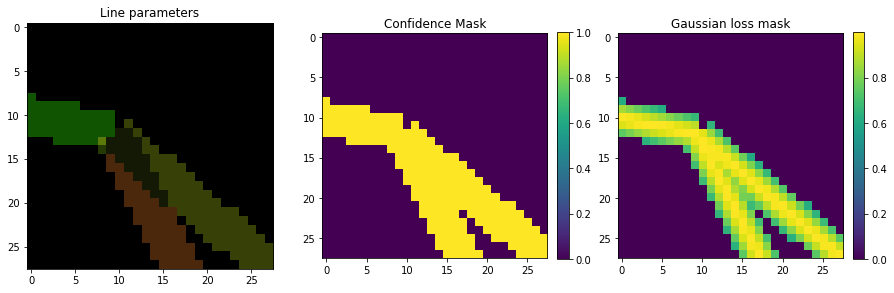

In [43]:
# Let's start by just training the initial neural network with known GT

# Given a set of line parameters, construct the ground truth:

def make_ground_truth(params,H,x0,y0,rf):
        
        theta = params[:,:3].unsqueeze(2).unsqueeze(3)
        cx = params[:,3]
        cy = params[:,4]
                 
        a = -torch.sin(theta)
        b = torch.cos(theta)
        c = torch.sin(theta)*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - torch.cos(theta)*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3)
        
#         a[:,1:,:,:] = - a[:,1:,:,:]
#         b[:,1:,:,:] = - b[:,1:,:,:]
#         c[:,1:,:,:] = - c[:,1:,:,:]
        
        # radius threshold 
#         rf = 15 # receptive field size (in the original image)
        r = rf/2*.8/H # divide the receptive field by 2, multiply by a factor .8 (because we want enough of the line to be included), and then scale by the size of the original (not cropped) image

        mask1 = (torch.abs(a*x0.unsqueeze(0).unsqueeze(1) + b*y0.unsqueeze(0).unsqueeze(1) + c)<r)
        mask2 = (b*x0.unsqueeze(0).unsqueeze(1) - a*y0.unsqueeze(0).unsqueeze(1) > b*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - a*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3) )

        # Create a gaussian mask that is the distance from the line
        sig = .1
        mask3 = torch.exp(-(a*x0.unsqueeze(0).unsqueeze(1) + b*y0.unsqueeze(0).unsqueeze(1) + c)**2/(2*sig**2))

        full_mask = mask1*mask2#*mask3
        full_mask = full_mask/torch.max(full_mask.view(params.shape[0],-1,3),1)[0].unsqueeze(2).unsqueeze(3)

        line_params = torch.stack((a,b,c),dim=4)
        

        print(line_params[:,0,:,:,:])
        print(line_params[:,1,:,:,:])
        print(line_params[:,2,:,:,:])
        
#         line_params[:,1,:,:,:] = - line_params[:,1,:,:,:]
#         line_params[:,2,:,:,:] = - line_params[:,2,:,:,:]
        line_params[:,0,:,:,:] = - line_params[:,0,:,:,:]
        
        ground_truth = torch.mean(line_params*(full_mask.unsqueeze(4)),1)#(line_params*(full_mask.unsqueeze(4))).sum(1)
        
#         confidence = mask2*mask3
#         confidence = confidence/torch.max(confidence.view(params.shape[0],-1,3),1)[0].unsqueeze(2).unsqueeze(3)
#         confidence,_ = torch.max(confidence,1)
        confidence,_ = torch.max(mask1*mask2,1)#.float()
    
        gaussian_mask,_ = torch.max(mask1*mask2*mask3,1)
        
        return ground_truth,confidence.float(),gaussian_mask
    
gt,c,gm = make_ground_truth(params[:,:,0,0],R,x0,y0,8)

print(gt.shape,c.shape,gm.shape)

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(torch.abs(gt[0].squeeze().cpu()))
# plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Line parameters')
plt.subplot(132)
plt.imshow(c[0].squeeze().cpu())
plt.title('Confidence Mask')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow(gm[0].squeeze().cpu())
plt.title('Gaussian loss mask')
# plt.subplots_adjust(wspace=0, hspace=.15)
plt.colorbar(fraction=0.046, pad=0.04)

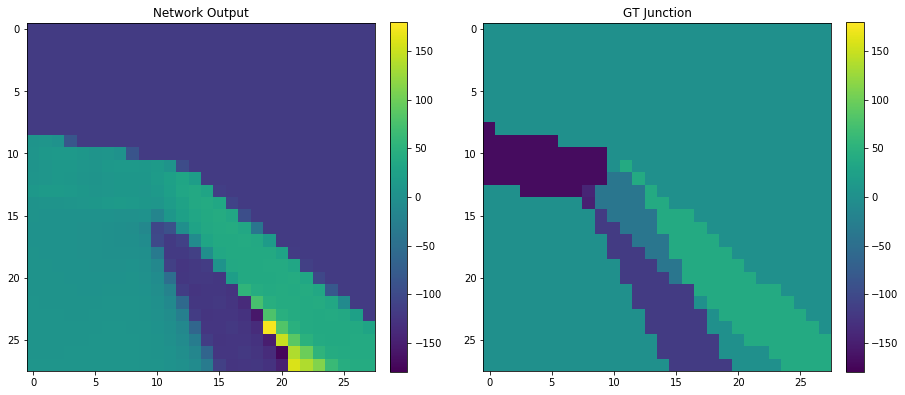

In [44]:
# print(torch.rad2deg(params[0,:3]))

# plt.figure(figsize=(15,5))
# plt.subplot(131)
# plt.imshow(gt[0,:,:,0])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(132)
# plt.imshow(gt[0,:,:,1])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(133)
# plt.imshow(gt[0,:,:,2])
# # plt.subplots_adjust(wspace=0, hspace=.15)
# plt.colorbar(fraction=0.046, pad=0.04)

#output_line_angles = torch.rad2deg(torch.atan2(-output_line_params[0,0,:,:],output_line_params[0,1,:,:]))
gt_line_angles = torch.rad2deg(torch.atan2(-gt[0,:,:,0],gt[0,:,:,1]))


plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(output_line_angles,vmin=-180,vmax=180)
plt.title('Network Output')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(gt_line_angles,vmin=-180,vmax=180)
plt.title('GT Junction')
plt.colorbar(fraction=0.046, pad=0.04)


torch.Size([28, 28])
torch.Size([28, 28])


Text(0.5, 1.0, 'GT Angles')

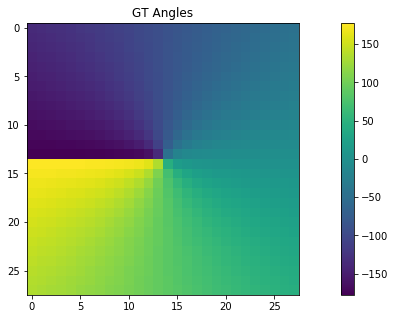

In [45]:
# Ground truth angles

print(x0.shape)
print(y0.shape)

angle_basis = torch.rad2deg(torch.atan2(y0,x0)) 

plt.figure(figsize=[15,5])
plt.imshow(angle_basis)
plt.colorbar()
plt.title('GT Angles')



torch.Size([1, 3, 28, 28])
torch.Size([1, 3, 28, 28])


Text(0.5, 1.0, 'Overall Parameter (a,b,c) Error')

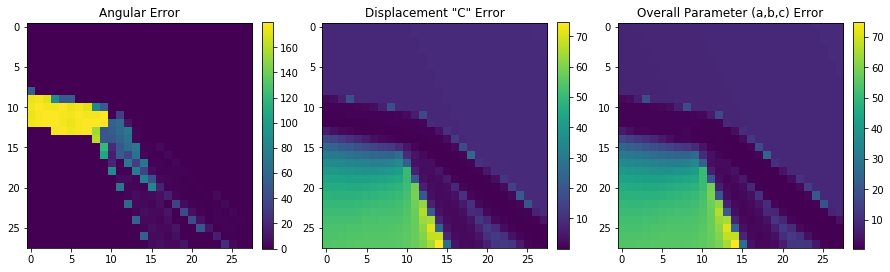

In [46]:
gt_params = gt.permute(0,3,1,2)
    
print(gt_params.shape) 
print(output_line_params_T.shape)
# Calculate angular loss

ang_loss = torch.abs(torch.rad2deg(torch.atan2(-gt_params[:,0,:,:]*output_line_params_T[:,1,:,:] + gt_params[:,1,:,:]*output_line_params_T[:,0,:,:]
                                     ,gt_params[:,1,:,:]*output_line_params_T[:,1,:,:]+gt_params[:,0,:,:]*output_line_params_T[:,0,:,:]).cpu())).squeeze()
    
    
plt.figure(figsize=[15,15])
plt.subplot(131)
plt.imshow(ang_loss*c[0].squeeze().cpu())
plt.title('Angular Error')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(torch.abs(gt_params[:,2,:,:]-output_line_params_T[:,2,:,:]).squeeze())
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Displacement "C" Error')
plt.subplot(133)
plt.imshow(torch.norm(output_line_params_T-gt_params,dim=1).squeeze())
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Overall Parameter (a,b,c) Error')


In [ ]:
# Find variance of original image divided according to line parameters 